# CS 7650 - Natural Language - HW - 1
Georgia Tech, Fall 2024 (Instructor: Kartik Goyal)

Welcome to the first full programming assignment for CS 7650!

In this assignment, you will be implementing different deep learning models for text classification using the [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/). It is esentially classifying news articles into different topics. This assignment will start with with data preprocessing techniques, implementing a baseline, and building up from there to more advanced model. It will cover basics of attention mechanism, something very central to modern NLP systems, and present you an opportunity to analyse different aspects of your training model.

This assignment will help you diver deeper into the world of Neural Networks and how to implement them for one application in Natural Language Processing. You are expected to have a good understanding of NumPy and PyTorch before starting this assignment.

- NumPy Quickstarter Guide: https://numpy.org/doc/stable/user/quickstart.html
- A good tutorial on PyTorch: https://www.youtube.com/watch?v=OIenNRt2bjg
- Detailed Documentation of PyTorch: https://pytorch.org/docs/stable/index.html
- Lecture Material on PyTorch and HuggingFace: https://github.com/neelabhsinha/cs7650-gatech-nlp-pytorch-huggingface-tutorial

DO NOT CHANGE the names of any of the files and contents outside the cells where you have to write code.

NOTE: DO NOT USE ANY OTHER EXTERNAL LIBRARIES FOR THIS ASSIGNMENT

<font color='red'> DEADLINE: September 30, 2024, 11:59 PM  </font><br>

The assignment is broken down into 6 Sections. The sections are as follows:

| Section | Part                                      | Points |
|---------|-------------------------------------------|--------|
| 1       | Loading and Preprocessing Data            | 7      |
| 2       | Neural Bag of Words (NBOW)                | 3      |
| 3       | Model Training (utilities for all models) | 15     |  
| 4       | Deep Averaging Networks (DANs)            | 8      |
| 5       | Attention-based Models                    | 30     |
| 6       | Perceptron and Hinge Losses               | 16     |
| 7       | Analysis                                  | 21     |
| 8       | Bonus: Improving Attention Models         | 10     |
| -       | Total                                     | 100 + 10 = 110     |


All the best and happy coding!

## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

# Check what version of Python is running
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [2]:
# execute only if you are working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# export
import os

In [4]:
# folder_path = '/content/drive/My Drive/path/to/folder/HW0'
# the above is what folder path should look like the folder path if you execute in colab
folder_path = '/content/drive/My Drive/CS 7650/HW1'

# Files in the folder -
os.listdir(folder_path)
os.chdir(folder_path)

In [5]:
# export
# Importing required libraries
# Do not change the libraries already imported or import additional libraries
import torch
import torch.nn as nn
import random
import numpy as np
from collections import Counter
import re
import html
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
# export
# SOME UTILITY FUNCTIONS - DO NOT CHANGE
def save_checkpoint(model, model_name, loss_fn='ce'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    os.makedirs(os.path.join(os.getcwd(), 'model_weights'), exist_ok=True)
    checkpoint = { # create a dictionary with all the state information
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, model_name, loss_fn='ce', map_location='cpu'):
    file_path = os.path.join(os.getcwd(), 'model_weights', f'checkpoint_{model_name}_{loss_fn}.pt')
    checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure correct device
    model.load_state_dict(checkpoint['model_state_dict'])

In [7]:
# SOME UTILITY FUNCTIONS - DO NOT CHANGE
def plot_loss(train_loss_over_time, val_loss_over_time, model_name):
    epochs = range(1, len(train_loss_over_time) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_over_time, color='red', label='Train Loss')
    plt.plot(epochs, val_loss_over_time, color='blue', label='Val Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
#export
# Defining global constants - DO NOT CHANGE THESE VALUES (except batch size if you have memory issues)
RANDOM_SEED = 42
PADDING_VALUE = 0
UNK_VALUE     = 1
BATCH_SIZE = 128

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else('mps' if torch.backends.mps.is_available() else 'cpu'))

In [9]:
# This is how we select a GPU if it's available on your computer or in the Colab environment.
print('Device of execution - ', device)

Device of execution -  cuda


## 1. Preprocessing [7 points - Programming]

### 1.1. Data Cleaning Methods [0 points]
The following cell defines some methods to clean the dataset. Do not edit it, but feel free to take a look at some of the operations it's doing.


In [10]:
#export
# example code taken from fast-bert
# DO NOT CHANGE THIS CELL

def spec_add_spaces(t: str) -> str:
    "Add spaces around / and # in `t`. \n"
    return re.sub(r"([/#\n])", r" \1 ", t)

def rm_useless_spaces(t: str) -> str:
    "Remove multiple spaces in `t`."
    return re.sub(" {2,}", " ", t)

def replace_multi_newline(t: str) -> str:
    return re.sub(r"(\n(\s)*){2,}", "\n", t)

def fix_html(x: str) -> str:
    "List of replacements from html strings in `x`."
    re1 = re.compile(r"  +")
    x = (
        x.replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace(" @,@ ", ",")
        .replace("\\", " \\ ")
    )
    return re1.sub(" ", html.unescape(x))

def clean_text(input_text):
    text = fix_html(input_text)
    text = replace_multi_newline(text)
    text = spec_add_spaces(text)
    text = rm_useless_spaces(text)
    text = text.strip()
    return text

### 1.2. Data Cleaning and Tokenizing [0 points]

Clean the data using the methods above and tokenize it using NLTK

In [11]:
# DO NOT CHANGE THIS CELL
# Downloading the NLTK tokenizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
# Tokenizing the text
df = pd.read_csv("vocab.csv")
df["tokenized"] = df["data"].apply(lambda x: nltk.word_tokenize(clean_text(x.lower())))
func = lambda x: int(x) if x.isdigit() else x
df['target'] = df['target'].apply(func)
print(df.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


(16962, 4)


In [12]:
# DO NOT CHANGE THESE VALUES
# Divide the dataset into training and validation sets
# The following two lines are used to load the indices of the training and validation sets
train_indices = np.load("train_indices.npy")
val_indices = np.load("valid_indices.npy")
# The following two lines are used to select the training and validation sets from the dataframe based on the indices loaded above
train_data = df.iloc[train_indices].reset_index(drop=True)
val_data = df.iloc[val_indices].reset_index(drop=True)
func = lambda x: int(x) if str(x).isdigit() else x
val_data['target'] = val_data['target'].apply(func)
val_data = val_data.iloc[1:, :].reset_index(drop=True)

Here's what the dataset looks like. You can index into specific rows with pandas, and try to guess some of these yourself :). If you're unfamiliar with pandas, it's a extremely useful and popular library for data analysis and manipulation. You can find their documentation [here](https://pandas.pydata.org/docs/).

Pandas primary data structure is a DataFrame. The following cell will print out the basic information of this structure, including the labeled axes (both columns and rows) as well as show you what the first n (default=5) rows look like

In [13]:
# Print training and validation set heads
train_data.head()

,data,target,target_names,tokenized
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,9,rec.sport.baseball,"[from, :, mamatha, devineni, ratnam, <, mr47+,..."
1,From: glazier@isr.harvard.edu (Andrew Baker Gl...,6,misc.forsale,"[from, :, glazier, @, isr.harvard.edu, (, andr..."
2,From: simon@dcs.warwick.ac.uk (Simon Clippingd...,0,alt.atheism,"[from, :, simon, @, dcs.warwick.ac.uk, (, simo..."
3,From: keith@cco.caltech.edu (Keith Allan Schne...,0,alt.atheism,"[from, :, keith, @, cco.caltech.edu, (, keith,..."
4,From: mz@moscom.com (Matthew Zenkar)\\nSubject...,1,comp.graphics,"[from, :, mz, @, moscom.com, (, matthew, zenka..."


In [14]:
# DO NOT CHANGE THIS CELL
id2label = dict(zip(df['target'], df['target_names']))
id2label = {k: id2label[k] for k in id2label if isinstance(k, int)}
id2label = {k: id2label[k] for k in sorted(id2label)}
id2label

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

This is a dictionary which maps ids to label names. It will be handy in the later part of the assignment.

### 1.3. Vocabulary Building [2 points - Programming]

Generate a vocabulary map for all the words in your dataset

Now that we've loaded this dataset, we need to create a vocab map for words, which will map tokens to numbers. This will be useful later, since torch PyTorch use tensors of sequences of numbers as inputs. **Go to the following cell, and fill out generate_vocab_map.**

In [15]:
# export

def generate_vocab_map(df, cutoff=2):
    """
    This method takes a dataframe and builds a vocabulary to unique number map.
    It uses the cutoff argument to remove rare words occurring <= cutoff times.
    "" and "UNK" are reserved tokens in our vocab that will be useful later.
    You'll also find the Counter imported for you to be useful as well.

    Args:
        df (pandas.DataFrame) : The entire dataset this mapping is built from
        cutoff (int) : We exclude words from the vocab that appear less than or equal to cutoff

    Returns:
        vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
            unique integer ID. Only elements that appear > cutoff times appear in vocab.
        reversed_vocab (dict[int] = str) : A reversed version of vocab, which allows us to retrieve
            words given their unique integer ID. This map will allow us to "decode" integer
            sequences we'll encode using vocab!
    """
    vocab          = {"": PADDING_VALUE, "UNK": UNK_VALUE}
    reversed_vocab = None

    ## YOUR CODE STARTS HERE ##
    # hint: start by iterating over df["tokenized"]

    # Use Counter to count word frequencies across the tokenized column
    word_counter = Counter()

    # Assuming the dataframe has a column 'tokenized' which contains lists of words
    for tokenized_text in df["tokenized"]:
        word_counter.update(tokenized_text)

    # Add words that occur more than the cutoff to the vocab
    for word, count in word_counter.items():
        if count > cutoff:
            vocab[word] = len(vocab)

    # Create reversed_vocab by swapping keys and values from vocab
    reversed_vocab = {idx: word for word, idx in vocab.items()}
    ## YOUR CODE ENDS HERE ##

    return vocab, reversed_vocab

With the methods you have implemented above, you can now generate your dictionaries mapping from word tokens to IDs (and vice versa).

In [16]:
# DO NOT CHANGE THIS CELL
train_vocab, reverse_vocab = generate_vocab_map(train_data)

In [17]:
# Check Vocabulary Size - DO NOT CHANGE THIS VALUE
assert len(train_vocab) == 60233, f"Vocabulary is of incorrect size: {len(train_vocab)}"

# No error means you've passed the test!

### 1.4. Building a Dataset Class [2 points - Programming]

PyTorch has custom Dataset Classes that have very useful extensions, we want to turn our current pandas DataFrame into a subclass of Dataset so that we can iterate and sample through it for minibatch updates. **In the following cell, fill out the HeadlineDataset class.** Refer to PyTorch documentation on [Dataset Classes](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
for help.

In [18]:
#export

class HeadlineDataset(Dataset):
    """
    This class takes a Pandas DataFrame and wraps in a Torch Dataset.
    Read more about Torch Datasets here:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """
    def __init__(self, vocab, df, max_length=200):
        """
        Initialize the class with appropriate instance variables. In this method, we
        STRONGLY recommend storing the dataframe itself as an instance variable, and
        keeping this method very simple. Leave processing to __getitem__.

        Args:
            vocab (dict[str] = int) : In vocab, each str is a unique token, and each dict[str] is a
                unique integer ID. Only elements that appear > cutoff times appear in vocab.
            df (pandas.DataFrame) : The entire dataset this mapping is built from
            max_length (int) : The max length of a headline we'll allow in our dataset.

        Returns:
            None
        """

        ## YOUR CODE STARTS HERE - initialize parameters ##
        self.vocab = vocab
        self.df = df
        self.max_length = max_length
        ## YOUR CODE ENDS HERE ##

    def __len__(self):
        """
        This method returns the length of the underlying dataframe,
        Args:
            None
        Returns:
            df_len (int) : The length of the underlying dataframe
        """

        df_len = None

        ## YOUR CODE STARTS HERE ##
        df_len = len(self.df)
        ## YOUR CODE ENDS HERE ##

        return df_len

    def __getitem__(self, index: int):
        """
        This method converts a dataframe row (row["tokenized"]) to an encoded torch LongTensor,
        using our vocab map created using generate_vocab_map. Restricts the encoded headline
        length to max_length.

        The purpose of this method is to convert the row - a list of words - into a corresponding
        list of numbers.

        i.e. using a map of {"hi": 2, "hello": 3, "UNK": 0}
        this list ["hi", "hello", "NOT_IN_DICT"] will turn into [2, 3, 0]

        Args:
            index (int) : The index of the dataframe we want to retrieve.

        Returns:
            tokenized_word_tensor (torch.LongTensor) : A 1D tensor of type Long, that has each
                token in the dataframe mapped to a number. These numbers are retrieved from the
                vocab_map we created in generate_vocab_map.

                IMPORTANT: If we filtered out the word because it's infrequent (and it doesn't
                exist in the vocab) we need to replace it w/ the UNK token

            curr_label (int) : Label index of the class between 0 to len(num_classes) - 1 representing which
            class label does this data instance belong to
        """

        tokenized_word_tensor = None
        curr_label            = None

        ## YOUR CODE STARTS HERE ##

        # Retrieve the row
        row = self.df.iloc[index]

        # Tokenize and encode the words using the vocab map
        tokenized_words = row["tokenized"]

        # Convert the list of words to encoded integers, replacing out-of-vocab words with "UNK"
        encoded_words = [
            self.vocab.get(word, self.vocab["UNK"])  # Use "UNK" for out-of-vocab words
            for word in tokenized_words
        ]

        # Truncate or pad the encoded words to max_length
        if len(encoded_words) > self.max_length:
            # Truncate the list to max_length
            encoded_words = encoded_words[:self.max_length]
        else:
            # Pad the list with the padding token (represented by "")
            encoded_words += [self.vocab[""]] * (self.max_length - len(encoded_words))

        # Convert the truncated/padded list to a torch LongTensor
        tokenized_word_tensor = torch.LongTensor(encoded_words)

        # Retrieve the label (if available in the row)
        curr_label = row["target"]

        ## YOUR CODE ENDS HERE ##

        return tokenized_word_tensor, curr_label

In [19]:
# DO NOT CHANGE THIS CELL
train_dataset = HeadlineDataset(train_vocab, train_data)
val_dataset   = HeadlineDataset(train_vocab, val_data)

# Now that we're wrapping our dataframes in PyTorch datsets, we can make use of PyTorch Random Samplers, they'll define how our DataLoaders sample elements from the HeadlineDatasets
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)

In [20]:
# Check Dataset Lengths - DO NOT CHANGE THESE VALUES
assert len(train_dataset) == 15076, f"Training Dataset is of incorrect size {len(train_dataset)}"
assert len(val_dataset)   ==  1885, f"Validation Dataset is of incorrect size {len(val_dataset)}"

# No error means you've passed the test!

### 1.5. Finalizing our DataLoader [3 points - Programming]

We can now use PyTorch DataLoaders to batch our data for us. **In the following cell fill out collate_fn.** Refer to PyTorch documentation on [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for help. Apply padding and other post-processing required here.

In [21]:
#export

def collate_fn(batch, padding_value=PADDING_VALUE):
    """
    This function is passed as a parameter to Torch DataSampler. collate_fn collects
    batched rows, in the form of tuples, from a DataLoader and applies some final
    pre-processing.

    Objective:
    In our case, we need to take the batched input array of 1D tokenized_word_tensors,
    and create a 2D tensor that's padded to be the max length from all our tokenized_word_tensors
    in a batch. We're moving from a Python array of tuples, to a padded 2D tensor.

    *HINT*: you're allowed to use torch.nn.utils.rnn.pad_sequence (ALREADY IMPORTED)

    Finally, you can read more about collate_fn here: https://pytorch.org/docs/stable/data.html

    :param batch: PythonArray[tuple(tokenized_word_tensor: 1D Torch.LongTensor, curr_label: int)] of length BATCH_SIZE
    :param padding_value: int

    :return padded_tokens: 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    :return y_labels: 1D FloatTensor of shape (BATCH_SIZE)
    """

    padded_tokens, y_labels = None, None

    ## YOUR CODE STARTS HERE - take the input and target from batch, pad the tokens, convert batches to tensor ##

    # Separate the tokenized tensors and the labels from the batch
    tokenized_word_tensors = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad the sequences to the maximum length in the batch
    padded_tokens = pad_sequence(tokenized_word_tensors, batch_first=True, padding_value=padding_value)

    # Convert labels to a LongTensor since labels are likely integers representing classes
    y_labels = torch.LongTensor(labels)

    ## YOUR CODE ENDS HERE ##

    return padded_tokens, y_labels

In [22]:
# DO NOT CHANGE THIS CELL
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)

In [23]:
# Use this to test your collate_fn implementation.
# You can look at the shapes of x and y or put print statements in collate_fn while running this snippet
# DO NOT CHANGE THIS CELL

for x, y in train_iterator:
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    break

x: torch.Size([128, 200])
y: torch.Size([128])


## 2. Neural Bag of Words (NBOW) [3 pts - Programming]
Let's move to modeling, now that we have dataset iterators that batch our data for us. The first model is a simple model called NBOW-RAND.

In the following code block, you'll build a feed-forward neural network implementing a neural bag-of-words baseline, NBOW-RAND, described in section 2.1 of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf). You'll find [this](https://pytorch.org/docs/stable/nn.html) page useful for understanding the different layers and [this](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) page useful for how to put them into action.

The core idea behind this baseline is that after we embed each word for a document, we average the embeddings to produce a single vector that hopefully captures some general information spread across the sequence of embeddings. This means we first turn each document of length *n* into a matrix of *nxd*, where *d* is the dimension of the embedding. Then we average this matrix to produce a vector of length *d*, summarizing the contents of the document and proceed with the rest of the network.

While you're working through this implementation, keep in mind how the dimensions change and what each axes represents, as documents will be passed in as minibatches requiring careful selection of which axes you apply certain operations too. Stick to only the architecture described in the instructions below, do not add additional layers, this will impact the validity of local checks.

Refer to the following equation on how to define NBOW -


$$ h_{avg} = \frac{1}{n} \sum_t emb(x_t) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T h_{avg}) $$

where $w \in R^d$ is a parameter vector.

*HINT*: In the forward step, the BATCH_SIZE is the first dimension.

*Hint*: Make sure to handle the case where the input contains pad tokens. We don't want to consider them in our average.

#### 2.1. Define the NBOW model class [3 points]

In [24]:
#export

class NBOW(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 2 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    #
    # HINT: In the forward step, the BATCH_SIZE is the first dimension.
    #
    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super().__init__()
        ## YOUR CODE STARTS HERE ##
        # Initialize the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Initialize the linear layer for classification
        self.fc = nn.Linear(embedding_dim, num_classes, bias=False)  # Remove bias
        ## YOUR CODE ENDS HERE ##

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## Hint: Make sure to handle the case where x contains pad tokens. We don't want to consider them in our average.
        ## YOUR CODE STARTS HERE ##
        # Get the embeddings for the input tokens
        embedded = self.embedding(x)  # Shape: (BATCH_SIZE, seq_len, embedding_dim)
        # Create a mask for the padded tokens (assuming padding index is 0)
        pad_mask = (x != 0).float()  # Shape: (BATCH_SIZE, seq_len)
        # Multiply embeddings by the mask to exclude padding in the sum
        h_sum = (embedded * pad_mask.unsqueeze(-1)).sum(dim=1)  # Shape: (BATCH_SIZE, embedding_dim)
        # Count the number of valid tokens in the batch
        valid_count = pad_mask.sum(dim=1, keepdim=True)  # Shape: (BATCH_SIZE, 1)
        # Average the embeddings by dividing by the number of valid tokens
        h_avg = h_sum / valid_count.clamp(min=1)  # Shape: (BATCH_SIZE, embedding_dim)
        # print(f"Averaged embeddings (h_avg): {h_avg}")
        # Pass the averaged embedding through the linear layer
        output = self.fc(h_avg)  # Output shape: (BATCH_SIZE, num_classes)
        # print(f"Output after linear layer: {output}")
        return output
        ## YOUR CODE ENDS HERE ##

    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight. Ensure you aren't recording gradients for this.
        Hint: Refer to nn.Parameter to do this.
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def get_h_avg(self, x):
        '''
        This function returns the average of the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        embedded = self.embedding(x)
        pad_mask = (x != 0).float()
        h_sum = embedded * pad_mask.unsqueeze(-1)  # Exclude padding in the sum
        h_sum = h_sum.sum(dim=1)
        valid_count = pad_mask.sum(dim=1, keepdim=True)
        h_avg = h_sum / valid_count.clamp(min=1)
        return h_avg
        ### YOUR CODE ENDS HERE ###

In [25]:
# local test for sanity:
# DO NOT CHANGE THIS CELL

def nbow_test_local():
    embedding_dim = 10
    vocab_size = 5
    model = NBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.1)
    input = torch.arange(12).reshape(2,6) % vocab_size
    expected_result = torch.tensor(
        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000, 0.1000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

def nbow_test_local_embeddings():
    embedding_dim = 3
    vocab_size = 5
    model = NBOW(embedding_dim=embedding_dim, vocab_size=vocab_size)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def nbow_test_local_h_avg():
    embedding_dim = 3
    vocab_size = 5
    model = NBOW(embedding_dim=embedding_dim, vocab_size=vocab_size)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    h_avg = model.get_h_avg(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_h_avg = torch.tensor([[0.1320, 0.1520, 0.1720],
                                  [0.1200, 0.1400, 0.1600]])
    if torch.allclose(h_avg, correct_h_avg, rtol=0.001):
        print("Passed local h_avg test")
    else:
        print(f"h_avg Test failed, expected value was\n{correct_h_avg}\nbut you got:\n{h_avg}")
nbow_test_local()
nbow_test_local_embeddings()
nbow_test_local_h_avg()

Passed local check
Passed local embedding test
Passed local h_avg test


## 3. Model Training [12 points - Programming + 3 points - Non-programming]

Training a PyTorch model involves several key components:

- **Training Loop**: This is the process where the model learns from the training data. In each iteration, the model processes the input data, makes predictions, calculates the loss, and updates its weights using backpropagation.
- **Validation Loop**: Performed after the training loop, this evaluates the model on a separate dataset (validation data) to check its performance. It helps in detecting overfitting.
- **Optimizer**: This is an algorithm that updates the model's weights during training. Common optimizers include SGD, Adam, etc.
- **Criterion (Loss Function)**: This measures how well the model is performing. It calculates the difference between the model's predictions and the actual data. Common loss functions include Mean Squared Error for regression tasks and Cross Entropy Loss for classification.

During training, the optimizer uses the gradient of the loss function to adjust the model's parameters. The model's performance is evaluated periodically on the validation set to monitor its generalization capability. This process continues for a specified number of epochs or until the model achieves a desired level of accuracy.

*Note - In the following code cells (of this section), the above components will be defined. These functions/objects will be used to train and evaluate all your models in this assignment. So, make sure to implement these in a generic way, so that they can be used for all the models.*


### 3.0. Evaluation Metrics [0 points]

Accuracy is a measure used to evaluate classification models, representing the ratio of correctly predicted observations to the total observations. It's simple and intuitive but may not be suitable for imbalanced datasets, as it can be misleading if the class distribution is skewed.

The F1-score, on the other hand, combines precision and recall into a single number. It is particularly useful when dealing with imbalanced datasets or when the cost of false positives and false negatives varies. F1-score provides a better measure of the incorrectly classified cases than the Accuracy Metric. It's calculated as the harmonic mean of precision and recall, thus balancing the two aspects of model performance.

You can read about the terms mentioned above here: https://scikit-learn.org/stable/modules/model_evaluation.html

For this assignment, we are already defining the above metrics for you to use in your implementation

In [26]:
#export
# DO NOT CHANGE THIS CELL
def get_accuracy_and_f1_score(y_true, y_predicted):
    """
    This function takes in two numpy arrays and computes the accuracy and F1 score
    between them. You can use the imported sklearn functions to do this.

    Args:
        y_true (list) : A 1D numpy array of ground truth labels
        y_predicted (list) : A 1D numpy array of predicted labels

    Returns:
        accuracy (float) : The accuracy of the predictions
        f1_score (float) : The F1 score of the predictions
    """

    # Get the accuracy
    accuracy = accuracy_score(y_true, y_predicted)

    # Get the F1 score
    f1 = f1_score(y_true, y_predicted, average='macro')

    return accuracy, f1


In [27]:
# DO NOT CHANGE THIS CELL
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

### 3.1. Criterion [2 points - Programming]

Criterion in PyTorch, refers to the loss function used to evaluate the model's performance. It quantifies how far off the model's predictions are from the actual target values

In PyTorch, **nn.CrossEntropyLoss()** is used for classification tasks. It first does a softmax on the scores, and then calculates the negative log likelihood. This is why you don't need to do sotmax in the model, you can return the scores. In the cell below, implement this.

In [28]:
#export

def get_criterion(loss_type='ce'):
    criterion = None

    ## YOUR CODE STARTS HERE ##
    if loss_type == 'ce':
        criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss is standard for classification tasks
    else:
        raise ValueError(f"Loss type '{loss_type}' not supported.")
    ## YOUR CODE ENDS HERE ##

    return criterion

### 3.2. Optimizer [2 points - Programming]

In PyTorch, an optimizer is a tool that updates the weights of the neural network to minimize the loss. Among these, Adam (Adaptive Moment Estimation) is a widely-used optimizer. Adam combines the best properties of the AdaGrad and RMSProp algorithms to handle sparse gradients on noisy problems. It's known for its effectiveness in deep learning models, especially where large datasets and high-dimensional spaces are involved. Adam adjusts the learning rate during training, making it efficient and effective across a wide range of tasks and model architectures.

In the cell below, define your optimizer. We recommend using Adam, but you are free to experiment with other optimizers as well.

The following function takes a model and learning rate value as input, and defines an optimizer for that model's parameters with that learning rate.

*HINT: model.parameters() can give you all the parameters of a PyTorch model*

In [29]:
#export
def get_optimizer(model, learning_rate):
    """
    This function takes a model and a learning rate, and returns an optimizer.
    Feel free to experiment with different optimizers.
    """
    optimizer = None

    ## YOUR CODE STARTS HERE ##
    import torch.optim as optim
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    ## YOUR CODE ENDS HERE ##

    return optimizer

### 3.3. Training Loop [3 points - Programming]

The training loop function in PyTorch is a critical component where the actual learning from data occurs. It typically involves iterating over the training dataset, feeding the data to the model, computing the loss (difference between the predictions and true values), and updating the model's weights.

Creating a training loop involves several steps:

1. Iterate Over Dataset: Loop through the training dataset, often in mini-batches.
2. Forward Pass: Feed the input data to the model to get predictions.
3. Compute Loss: Calculate the loss using a loss function.
4. Backward Pass: Perform backpropagation by calling loss.backward(), which computes the gradient of the loss function with respect to each weight.
5. Update Weights: Use an optimizer (like SGD or Adam) to adjust the weights based on the gradients calculated.
6. Zero the Gradients: Reset the gradients to zero after each mini-batch to prevent accumulation of gradients from multiple passes.

This loop repeats for a specified number of epochs or until a certain level of accuracy or loss is achieved.

In the end, return the mean loss over all samples for this particular iteration

In [30]:
#export
def train_loop(model, criterion, optimizer, iterator, epoch, save_every=10):
    """
    This function is used to train a model for one epoch.
    :param model: The model to be trained
    :param criterion: The loss function
    :param optim: The optimizer
    :param iterator: The training data iterator
    :return: The average loss for this epoch
    """
    model.train() # Is used to put the model in training mode
    total_loss = 0
    device = next(model.parameters()).device  # Get the device of the model
    for x, y in tqdm(iterator, total=len(iterator), desc="Training Model"):
        ### YOUR CODE STARTS HERE ###
        # Ensure that the target labels (y) are long integers and on the correct device
        y = y.to(device).long()
        x = x.to(device)
        # Zero the gradients before each batch
        optimizer.zero_grad()
        # Forward pass
        output = model(x)
        # Compute loss
        loss = criterion(output, y)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Accumulate loss
        total_loss += loss.item()
        ### YOUR CODE ENDS HERE ###

    average_loss = total_loss / len(iterator)
    return average_loss

### 3.4. Validation Loop [3 points - Programming]

The validation loop in PyTorch is where the model's performance is evaluated on a dataset different from the one used for training. It does not involve updating the model's weights, focusing instead on assessing how well the model generalizes to new data. Here's how it typically works:

1. Iterate Over Validation Dataset: Loop through the validation dataset, usually in mini-batches, without the need for shuffling as in the training loop.
2. Forward Pass: Feed the input data to the model to obtain predictions.
3. Compute Loss: Calculate the loss (e.g., Cross-Entropy, Mean Squared Error) to assess the performance on the validation dataset.
4. Calculate Metrics: Besides loss, other performance metrics like accuracy, F1 score, etc., are computed to evaluate model performance.

Note: No Backpropagation: Unlike the training loop, there is no backward pass or weight updates.

The validation loop is crucial for monitoring overfitting and tuning hyperparameters. It provides insight into how the model is likely to perform on unseen data.

In [31]:
# export
def val_loop(model, criterion, iterator):
    """
    This function is used to evaluate a model on the validation set.
    :param model: The model to be evaluated
    :param iterator: The validation data iterator
    :return: true: a Python boolean array of all the ground truth values
             pred: a Python boolean array of all model predictions.
            average_loss: The average loss over the validation set
    """

    true, pred = [], []
    total_loss = 0
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model
    for x, y in tqdm(iterator, total=len(iterator), desc="Evaluating Model"):
    ### YOUR CODE STARTS HERE ###
        # Move inputs and targets to the same device as the model
        x, y = x.to(device), y.to(device)
        # Forward pass
        output = model(x)
        # Compute loss
        loss = criterion(output, y)
        total_loss += loss.item()
        # Collect true and predicted labels
        true.extend(y.tolist())
        pred.extend(output.argmax(dim=1).tolist())
    ### YOUR CODE ENDS HERE ###
    average_loss = total_loss / len(iterator)
    return true, pred, average_loss

### 3.5. Training NBOW [3 points - Non-programming]
Assign and tune the below hyperparameters to optimize your model. Make sure that the output graph of the cell where training happens is clear in your submission.

In [32]:
#export
# Assigning hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_nbow():
  ### your hyper parameters
  learning_rate = 0.01
  epochs = 5
  embedding_dim = 200
  ###
  return learning_rate, epochs, embedding_dim

Since the NBOW model is rather basic, assuming you haven't added any additional layers, there's really only one hyperparameter for the model architecture: the size of the embedding dimension.

The vocab_size parameter here is based on the number of unique words kept in the vocab after removing those occurring too infrequently, so this is determined by our dataset and is in turn not a true hyperparameter (though the cutoff we used previously might be). The embedding_dim parameter dictates what size vector each word can be embedded as.

A special note concerning the model initialization: We're specifically sending the model to the device set in Part 1, to speed up training if the GPU is available. **Be aware**, you'll have to ensure other tensors are on the same device inside your training and validation loops.

In [33]:
# export
def get_nbow_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the NBOW model.
    """
    model = None
    # Define a model and return
    # YOUR CODE STARTS HERE
    # Initialize the model
    model = NBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)

    # Move the model to the specified device (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # YOUR CODE ENDS HERE
    return model

In [34]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_nbow = []
val_loss_over_time_nbow = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
    train_loss_over_time_nbow.append(train_loss)
    val_loss_over_time_nbow.append(val_loss)
save_checkpoint(nbow_model, 'nbow')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 35.95it/s]


Epoch 1 -- Train_Loss: 2.0627266946485485 -- Val_Loss: 0.9773003300031026 -- Val_Accuracy: 0.7973474801061008 -- Val_F1: 0.7914538183015849


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 40.09it/s]


Epoch 2 -- Train_Loss: 0.46553706062042105 -- Val_Loss: 0.4192931433518728 -- Val_Accuracy: 0.8949602122015915 -- Val_F1: 0.8916162019497266


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 38.04it/s]


Epoch 3 -- Train_Loss: 0.13346639499699664 -- Val_Loss: 0.3287927210330963 -- Val_Accuracy: 0.9161803713527852 -- Val_F1: 0.9133172159680596


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 38.87it/s]


Epoch 4 -- Train_Loss: 0.0509159428272712 -- Val_Loss: 0.29674145181973777 -- Val_Accuracy: 0.9193633952254642 -- Val_F1: 0.9168615968944334


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 39.63it/s]


Epoch 5 -- Train_Loss: 0.025205831753753 -- Val_Loss: 0.2780256927013397 -- Val_Accuracy: 0.9251989389920424 -- Val_F1: 0.922334861278282
Checkpoint saved to /content/drive/MyDrive/CS 7650/HW1/model_weights/checkpoint_nbow_ce.pt


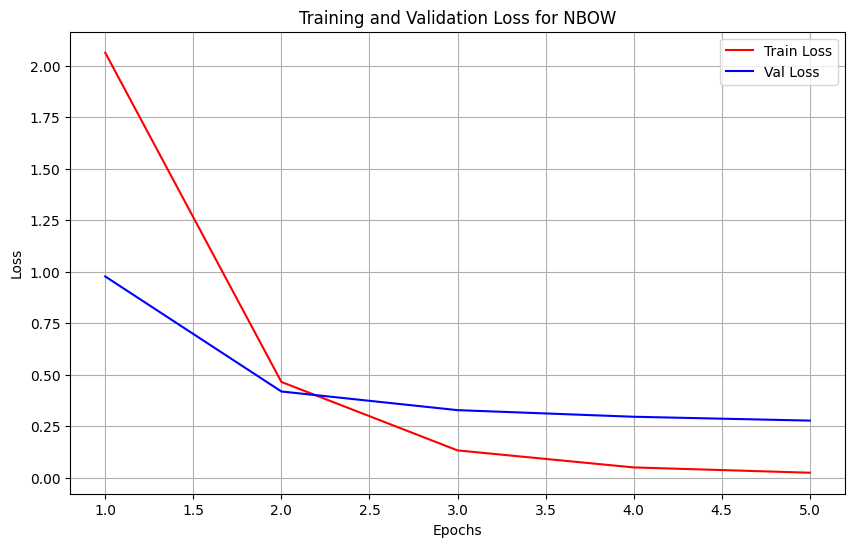

In [35]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits
plot_loss(train_loss_over_time_nbow, val_loss_over_time_nbow, 'NBOW')

### 3.6. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 84%
- 1 point for accuracy > 84% but <= 88%
- 2 points for accuracy > 88%

In [36]:
# load best model from checkpoint
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', map_location=device)

# evaluate model
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

Final Validation Accuracy: 0.9251989389920424
Final Validation F1-Score: 0.922334861278282


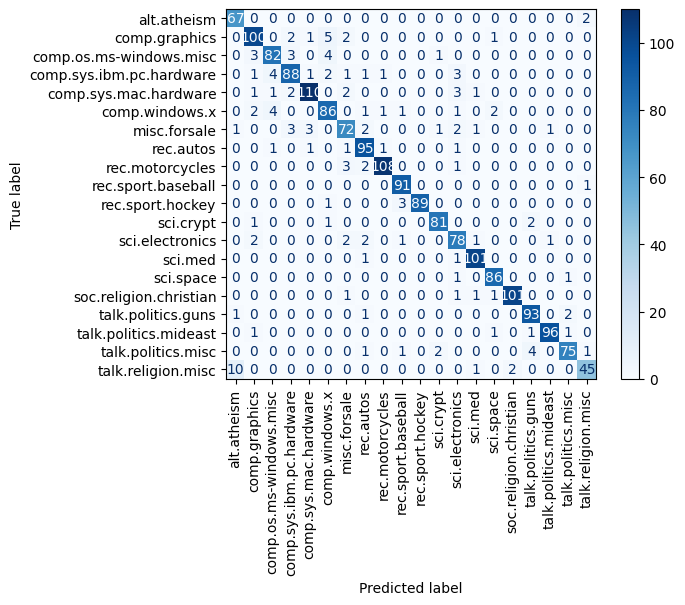

In [37]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 4. Simple Deep Averaging Networks (DAN) [5 points - Programming + 3 points - Non-programming]

Now, let's look at how to improve performance of the NBOW model. One such way without drastically changing the model complexity is DAN.

The core idea of a DAN is to simplify the process of understanding text by averaging the embeddings of words in a sentence or document. This creates a single vector representation that captures the overall meaning of the text.

In implementation, a DAN typically involves the following steps:

1. Convert each token into an embedding.
2. Average these embeddings to create a single vector that represents the entire document.
3. Pass this averaged vector through one hidden fully connected neural network layer.
4. Use ReLU activation
5. Use the output of these layers for tasks like classification.

This approach is simpler and often faster than more complex architectures like LSTMs or Transformers, while still providing robust performance for many tasks. However, it might not capture nuances in language as effectively as these more complex models.

*NOTE*: Use the same approach to handle pad_tokens as you used in NBOW.

### 4.1. Model Definition [3 points - Programming]

In the following cell, define the architecture of a DAN in the same way as you implemented NBOW-RAND in Section 2 with. Use the following image as a reference along with Section 3 and Figure 1 (right) of [this paper](https://www.aclweb.org/anthology/P15-1162.pdf).

Refer to the following equation on how to define DAN -


$$ h_{avg} = \frac{1}{n} \sum_t emb(x_t) $$

$$ h_2 = (w_1h_{avg}) $$

$$ h'_{2} = max(0, h_2) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w_2^T h'_{2} + b) $$

where $w \in R^d$ is a parameter vector.

*Hint*: Make sure to handle the case where the input contains pad tokens. We don't want to consider them in our average.


In [38]:
# export
class DAN(nn.Module):
    # Instantiate layers for your model-
    #
    # Your model architecture will be a feed-forward neural network.
    #
    # You'll need 4 nn.Modules:
    # 1. An embeddings layer (see nn.Embedding)
    # 2. A linear layer (see nn.Linear)
    # 3. A ReLU activation (see nn.ReLU)
    # 4. A linear layer (see nn.Linear)
    #
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=20):
        # vocab_size is the size of the vocabulary
        # embedding_dim is the dimension of the word embeddings
        # hidden_dim is the dimension of the hidden layer outputs, i.e., the 2nd module as per the definition above
        super().__init__()
        ## YOUR CODE STARTS HERE ##
        # Embedding layer with padding token handling
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Hidden linear layer (w1) without bias
        self.hidden = nn.Linear(embedding_dim, hidden_dim, bias=False)
        # ReLU activation
        self.relu = nn.ReLU()
        # Output linear layer (w2) with bias for classification
        self.output = nn.Linear(hidden_dim, num_classes)
        ## YOUR CODE ENDS HERE ##

    # Complete the forward pass of the model.
    #
    # Use the output of the embedding layer to create
    # the average vector, which will be input into the
    # linear layer.
    #
    # args:
    # x - 2D LongTensor of shape (BATCH_SIZE, max len of all tokenized_word_tensor))
    #     This is the same output that comes out of the collate_fn function you completed
    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        # Get embeddings for the input words (BATCH_SIZE, max_len, embedding_dim)
        embeddings = self.embedding(x)
        # Create a mask to ignore padding tokens
        mask = (x != 0).unsqueeze(-1).float()  # Shape: (BATCH_SIZE, max_len, 1)
        # Mask out the padding tokens in embeddings
        masked_embeddings = embeddings * mask
        # Compute the average of the embeddings, ignoring padding
        # Add a small epsilon to avoid division by zero
        avg_embedding = masked_embeddings.sum(dim=1) / (mask.sum(dim=1) + 1e-8)
        # Apply the hidden layer transformation (without bias)
        h2 = self.hidden(avg_embedding)  # Shape: (BATCH_SIZE, hidden_dim)
        # Apply ReLU activation
        h_prime_2 = self.relu(h2)
        # Apply the final linear layer to get class logits
        logits = self.output(h_prime_2)  # Shape: (BATCH_SIZE, num_classes)
        return logits  # Return raw logits for use in loss functions like CrossEntropyLoss


        ## YOUR CODE ENDS HERE ##

    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        self.embedding.weight = nn.Parameter(weight, requires_grad=False)
        ### YOUR CODE ENDS HERE ###

    def get_hidden(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        embeddings = self.embedding(x)
        mask = (x != 0).unsqueeze(-1).float()
        masked_embeddings = embeddings * mask
        avg_embedding = masked_embeddings.sum(dim=1) / (mask.sum(dim=1) + 1e-8)
        h2 = self.hidden(avg_embedding)
        return self.relu(h2)
        ### YOUR CODE ENDS HERE ###

    def set_hidden_weight(self, weight, bias):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (embedding_dim, hidden_dim)
            bias: torch.tensor of shape (1, hidden_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        self.hidden.weight = nn.Parameter(weight, requires_grad=False)
        self.hidden.bias = nn.Parameter(bias, requires_grad=False)
        ### YOUR CODE ENDS HERE ###


In [39]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def dan_test_local_embeddings():
    embedding_dim = 3
    vocab_size = 5
    model = DAN(embedding_dim=embedding_dim, vocab_size=vocab_size, hidden_dim=10)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")

def dan_test_local_hidden_layer():
    vocab_size = 5
    embedding_dim = 3
    hidden_dim = 3

    model = DAN(vocab_size, embedding_dim, hidden_dim)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_hidden_weight(torch.arange(9).reshape(embedding_dim, hidden_dim) / 50, torch.arange(3).reshape(1, hidden_dim) / 50)

    output = model.get_hidden(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_output = torch.tensor([[0.0099, 0.0573, 0.1046],
                                    [0.0092, 0.0544, 0.0996]])

    if torch.allclose(output, correct_output, atol=0.001):
        print("Passed local hidden layer test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_output}\nbut you got:\n{output}")

dan_test_local_embeddings()
dan_test_local_hidden_layer()

Passed local embedding test
Passed local hidden layer test


### 4.2. DAN Training [3 points - Non-programming]

In this section (and all later sections), you will leverage the same functions defined in Section 3 to train your DAN. To do this, simply initialize your DAN Model and pass that object to the training and evaluation loop to train your model.

Assign and tune the below hyperparameters to optimize your model

In [40]:
# export
def get_dan_model(vocab_size, embedding_dim, hidden_dim):
    """
    This function returns an instance of the DAN model. Initialize the DAN model here and return it. Note that the hidden_dim will be the dimension of the hidden layer in DAN.
    """
    model = None
    ## YOUR CODE STARTS HERE ##
    # Initialize and return a DAN model
    model = DAN(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim)
    ## YOUR CODE ENDS HERE ##
    return model

In [41]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_dan():
  ### your hyper parameters
    learning_rate = 0.01
    epochs = 5
    hidden_layer_dimensions = 20
    embedding_dim = 200
    ###
    return learning_rate, epochs, hidden_layer_dimensions, embedding_dim


In [42]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, hidden_layer_dimensions, embedding_dim = get_hyperparams_dan()
dan_model = get_dan_model(len(train_vocab.keys()), embedding_dim, hidden_layer_dimensions).to(device)
criterion = get_criterion()
optimizer = get_optimizer(dan_model, learning_rate)
train_loss_over_time_dan = []
val_loss_over_time_dan = []
for epoch in range(epochs):
    train_loss = train_loop(dan_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(dan_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_dan.append(train_loss)
    val_loss_over_time_dan.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

save_checkpoint(dan_model, 'dan')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 37.51it/s]


Epoch 1 -- Train_Loss: 2.1734364921763794 -- Val_Loss: 1.0596367359161376 -- Val_Accuracy: 0.6986737400530504 -- Val_F1: 0.6830557958332283


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 38.89it/s]


Epoch 2 -- Train_Loss: 0.5190190879975335 -- Val_Loss: 0.5073210000991821 -- Val_Accuracy: 0.8594164456233422 -- Val_F1: 0.8569333695321275


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 40.49it/s]


Epoch 3 -- Train_Loss: 0.12967044108752476 -- Val_Loss: 0.4315153300762177 -- Val_Accuracy: 0.8811671087533156 -- Val_F1: 0.8790036460313255


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 39.32it/s]


Epoch 4 -- Train_Loss: 0.0380276262965369 -- Val_Loss: 0.4048586746056875 -- Val_Accuracy: 0.893368700265252 -- Val_F1: 0.891302519236346


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 39.44it/s]


Epoch 5 -- Train_Loss: 0.016463363235342806 -- Val_Loss: 0.42691981196403506 -- Val_Accuracy: 0.8912466843501327 -- Val_F1: 0.8900508830657028
Checkpoint saved to /content/drive/MyDrive/CS 7650/HW1/model_weights/checkpoint_dan_ce.pt


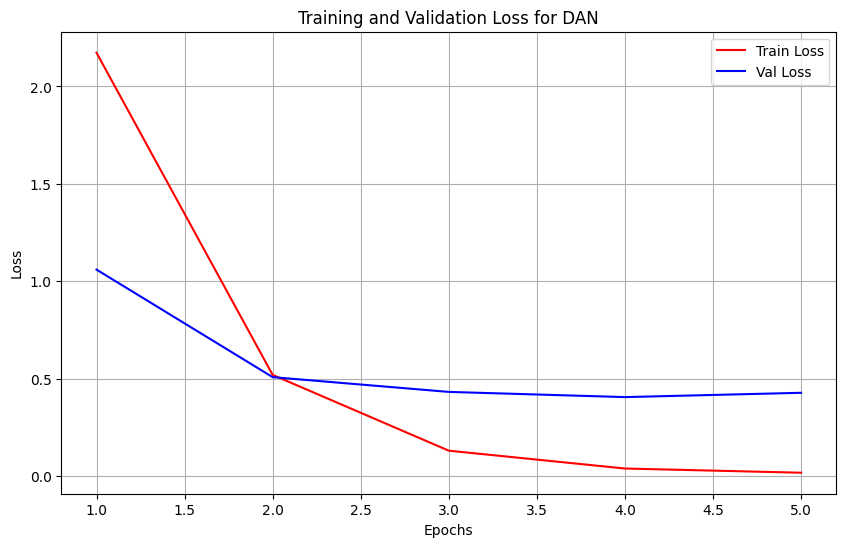

In [43]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF to get credits
plot_loss(train_loss_over_time_dan, val_loss_over_time_dan, 'DAN')

### 4.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 84%
- 1 point for accuracy > 84% but <= 88%
- 2 points for accuracy > 88%

In [44]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, hidden_layer_dimensions, embedding_dim = get_hyperparams_dan()
dan_model = get_dan_model(len(train_vocab.keys()), embedding_dim, hidden_layer_dimensions).to(device)
load_checkpoint(dan_model, 'dan', map_location=device)

true, pred, val_loss = val_loop(dan_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

Final Validation Accuracy: 0.8912466843501327
Final Validation F1-Score: 0.8900508830657028


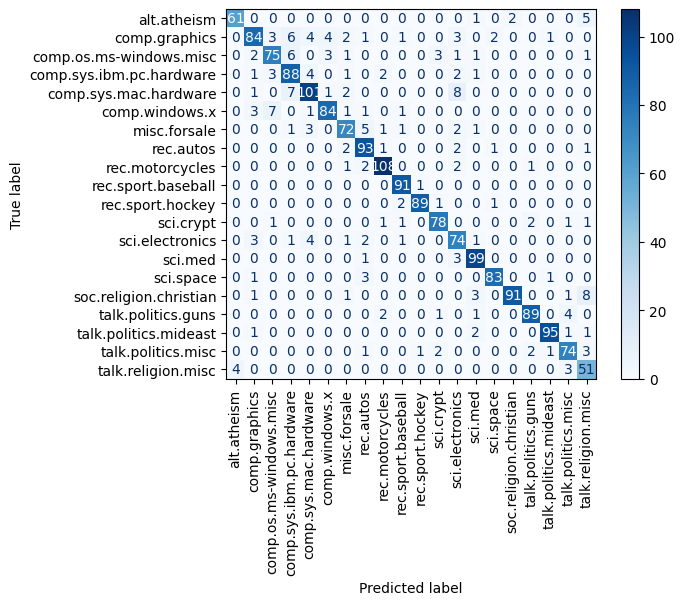

In [45]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 5. Attention-based Models [21 points - Programming + 9 points - Non-programming]
 In the simplest terms, attention allows a network to differentially focus on specific input words rather considering their importance equally, as done in the previous sections by averaging. For example, often times the mere presence of word "election" is enough to ascertain the category of the sentence to be politics.

 There are various types of attention which we will dsicuss in much more depth throughout course. This section is just to provide a conceptual flavor of attention as a concept. In the below parts, you will work with three different simple types of attention.

### 5.1. Attention-weighted NBOW [7 points - Programming + 3 points - Non-programming]



You will now define an encoder that uses a simple attention function to produce a weight for each word in the sentence followed by a sum of the attention-weighted word embeddings. Simple attention allows the model to learn a weight vector $\alpha_t$ which represents how important will different tokens in a document be.

Consider $u$ to be a single attention head (a learnable PyTorch parameter). With this,

$$ \alpha_t \varpropto \exp\{cos(u,emb(x_t))\} $$

*Note*: This needs to be normalized.

$$ h_{att} = \sum_t \alpha_t emb(x_t) $$

The probability of a data instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T h_{att}) $$

where $w \in R^d$ is a parameter vector.

In this model, the unnormalized attention weight for a word $x$ is computed using the cosine similarity between a learnable parameter $u$ and the word embedding for $x$ followed by exponentiation. To get normalized weights $\alpha_t$, normalize across all words in the sentence. Then multiply the attention weights by the word embeddings and sum the attention-weighted embeddings.

*HINT*: See if Softmax function can help with this

*Hint*: Make sure to handle the case where the input contains pad tokens.

#### 5.1.1. Model Definition [5 points - Programming]

Define your simple attention model below.

In [46]:
#export

class SimpleAttentionNBOW(nn.Module):
    """
    This class implements the Attention-weighted Neural Bag of Words model.
    """

    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super(SimpleAttentionNBOW, self).__init__()
        ## YOUR CODE STARTS HERE ##
        # Embedding layer: Converts words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Attention vector (learnable parameter)
        self.attention_u = nn.Parameter(torch.randn(embedding_dim))
        # Linear layer for classification
        self.fc = nn.Linear(embedding_dim, num_classes, bias=False)
        ## YOUR CODE ENDS HERE ##

    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        # 1: Get embeddings for the input words
        embedded = self.embedding(x)  # Shape: (BATCH_SIZE, seq_len, embedding_dim)
        # Create a mask to handle padding tokens (assuming padding index is 0)
        pad_mask = (x != 0).float()  # Shape: (BATCH_SIZE, seq_len)
        # 2: Compute unnormalized attention weights using cosine similarity
        # between the attention vector u and each word embedding
        attn_scores = F.cosine_similarity(embedded, self.attention_u.unsqueeze(0).unsqueeze(0), dim=-1)  # Shape: (BATCH_SIZE, seq_len)
        # Apply the padding mask (set scores for padding tokens to a very large negative number)
        attn_scores = attn_scores * pad_mask + (1 - pad_mask) * torch.finfo(torch.float32).min
        # 3: Normalize attention scores with softmax
        attn_weights = F.softmax(attn_scores, dim=1)  # Shape: (BATCH_SIZE, seq_len)
        # 4: Multiply the attention weights by the embeddings
        attn_weights = attn_weights.unsqueeze(-1)  # Shape: (BATCH_SIZE, seq_len, 1)
        attn_weighted_embeddings = embedded * attn_weights  # Shape: (BATCH_SIZE, seq_len, embedding_dim)
        # 5: Sum the attention-weighted embeddings to get h_att
        h_att = attn_weighted_embeddings.sum(dim=1)  # Shape: (BATCH_SIZE, embedding_dim)
        # 6: Pass h_att through the linear layer to get class logits (NO SOFTMAX HERE)
        predictions = self.fc(h_att)  # Shape: (BATCH_SIZE, num_classes)
        ## YOUR CODE ENDS HERE ##

        return predictions

    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def set_attention_weights(self, weight):
        '''
        This function sets the attention weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.attention_u.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        '''
        ### YOUR CODE STARTS HERE ###
        embedded = self.embedding(x)  # Shape: (BATCH_SIZE, seq_len, embedding_dim)
        # Create a mask to handle padding tokens
        pad_mask = (x != 0).float()  # Shape: (BATCH_SIZE, seq_len)
        # Compute attention scores using cosine similarity
        attn_scores = F.cosine_similarity(embedded, self.attention_u.unsqueeze(0).unsqueeze(0), dim=-1)  # Shape: (BATCH_SIZE, seq_len)
        # Apply the padding mask (set scores for padding tokens to a very large negative number)
        attn_scores = attn_scores * pad_mask + (1 - pad_mask) * torch.finfo(torch.float32).min
        # Normalize attention scores using softmax
        attn_weights = F.softmax(attn_scores, dim=1)  # Shape: (BATCH_SIZE, seq_len)
        return attn_weights
        ### YOUR CODE ENDS HERE ###


In [47]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def simple_attention_nbow_test_local_embeddings():
    model = SimpleAttentionNBOW(embedding_dim=3, vocab_size=5)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def simple_attention_nbow_test_local_attn():
    model = SimpleAttentionNBOW(embedding_dim=3, vocab_size=5)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_attention_weights(torch.tensor([0.1, 0.2, 0.3]))
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[0.2033, 0.1995, 0.1975, 0.1964, 0.2033],
                                              [0.3387, 0.3323, 0.3290, 0.0000, 0.0000]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")

simple_attention_nbow_test_local_embeddings()
simple_attention_nbow_test_local_attn()

Passed local embedding test
Passed local Attn test


#### 5.1.2. Model Training [3 points - Non-Programming]
Assign and tune the below hyperparameters to optimize your model

In [48]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_simple_attention():
  ### your hyper parameters
    learning_rate = 0.01
    epochs = 5
    embedding_dim = 200
    return learning_rate, epochs, embedding_dim

In [49]:
# export
def get_simple_attention_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the SimpleAttentionNBOW model. Initialize the SimpleAttentionNBOW model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##
    model = SimpleAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    ## YOUR CODE ENDS HERE ##
    return model

In [50]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_simple_attention()
simple_attention_model = get_simple_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim).to(device)
criterion = get_criterion()
train_loss_over_time_sa = []
val_loss_over_time_sa = []
optimizer = get_optimizer(simple_attention_model, learning_rate)
for epoch in range(epochs):
    train_loss = train_loop(simple_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(simple_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_sa.append(train_loss)
    val_loss_over_time_sa.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(simple_attention_model, 'simple_attention')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 35.49it/s]


Epoch 1 -- Train_Loss: 1.9724704628273593 -- Val_Loss: 0.8337767601013184 -- Val_Accuracy: 0.8212201591511936 -- Val_F1: 0.8153179165446355


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 37.50it/s]


Epoch 2 -- Train_Loss: 0.3677052830235433 -- Val_Loss: 0.3657239278157552 -- Val_Accuracy: 0.9050397877984084 -- Val_F1: 0.9016341887561105


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 37.15it/s]


Epoch 3 -- Train_Loss: 0.09232103985623788 -- Val_Loss: 0.29284505049387616 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9246838261222221


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 39.32it/s]


Epoch 4 -- Train_Loss: 0.031432497938621344 -- Val_Loss: 0.2753125846385956 -- Val_Accuracy: 0.9241379310344827 -- Val_F1: 0.9232823704390469


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 37.68it/s]


Epoch 5 -- Train_Loss: 0.015088404990511678 -- Val_Loss: 0.2642754395802816 -- Val_Accuracy: 0.926790450928382 -- Val_F1: 0.9246029397681962
Checkpoint saved to /content/drive/MyDrive/CS 7650/HW1/model_weights/checkpoint_simple_attention_ce.pt


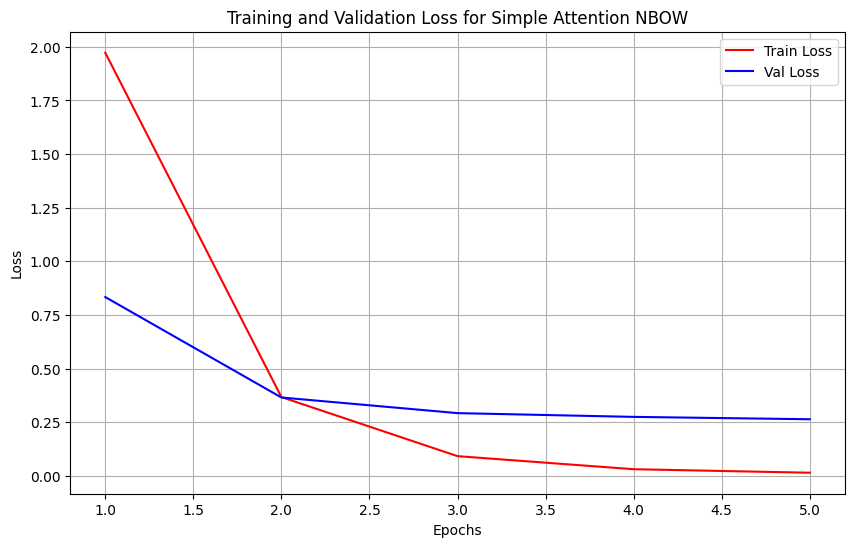

In [51]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF to get credits
plot_loss(train_loss_over_time_sa, val_loss_over_time_sa, 'Simple Attention NBOW')

#### 5.1.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [52]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_simple_attention()
simple_attention_model = get_simple_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim).to(device)
load_checkpoint(simple_attention_model, 'simple_attention', map_location=device)

true, pred, val_loss = val_loop(simple_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

Final Validation Accuracy: 0.926790450928382
Final Validation F1-Score: 0.9246029397681962


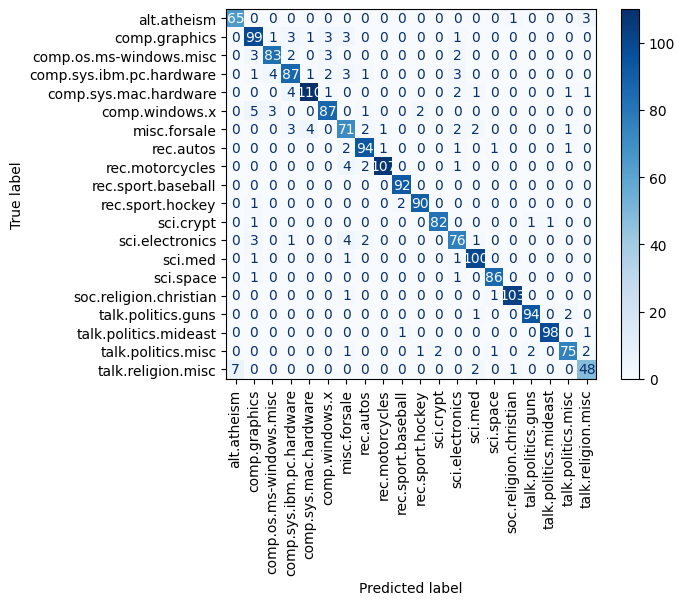

In [53]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 5.2. MultiHead Attention NBOW [7 points - Programming + 3 points - Non-programming]

The prior model only uses a single attention function. In this section, you will implement a multi-head attention model. You will use $k$ attention heads, each with its own parameters $u_i \in R^d$ ($\forall i \in [1..k]$) and a single large vector before the classification to weight them all together $w \in R^{d \cdot k}$.

$$ \alpha_{t,i} \varpropto \exp\{cos(u_i,emb(x_t))\} $$

$$ h_{att}(i) = \sum_t\alpha_{t,i} emb(x_t) $$

With the probability of a task instance belonging to class $y_i$ is given by:

$$ p(y|x) = softmax(w^T [h_{att}(1), h_{att}(2), ..., h_{att}(k)]) $$

where [a,b] is the concatenation of vectors $a$ and $b$, into a single taller vector.

#### 5.2.1. Model Definition [5 points - Programming]

Define your Multi-head attention below

In [54]:
#export

class MultiHeadAttentionNBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_classes=20):
        ## YOUR CODE STARTS HERE ##
        super(MultiHeadAttentionNBOW, self).__init__()
        # Embedding layer: Converts words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Embedding layer for attention heads: Generates a learnable vector based on the head index
        self.head_embedding = nn.Embedding(num_heads, embedding_dim)
        # Linear layer for classification, the input is embedding_dim * num_heads due to concatenation
        self.fc = nn.Linear(embedding_dim * num_heads, num_classes, bias=False)  # Remove bias
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        ## YOUR CODE ENDS HERE ##

    def forward(self, x):
        ## YOUR CODE STARTS HERE ##
        # Get embeddings for the input words
        embedded = self.embedding(x)  # Shape: (BATCH_SIZE, seq_len, embedding_dim)
        # Create a mask to handle padding tokens (assuming padding index is 0)
        pad_mask = (x != 0).float()  # Shape: (BATCH_SIZE, seq_len)
        # Compute attention scores for each head
        head_outputs = []
        for i in range(self.num_heads):
            # Generate the embedding for the current head using the head index
            u_i = self.head_embedding(torch.tensor(i, device=x.device)).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, embedding_dim)
            # Compute cosine similarity for this head
            attn_scores = F.cosine_similarity(embedded, u_i, dim=-1)  # Shape: (BATCH_SIZE, seq_len)
            # Apply padding mask (set attention scores for padding tokens to a very large negative number)
            attn_scores = attn_scores * pad_mask + (1 - pad_mask) * torch.finfo(torch.float32).min
            # Normalize attention scores using softmax
            attn_weights = F.softmax(attn_scores, dim=1)  # Shape: (BATCH_SIZE, seq_len)
            # Multiply attention weights by embeddings and sum to get weighted representation
            attn_weights = attn_weights.unsqueeze(-1)  # Shape: (BATCH_SIZE, seq_len, 1)
            attn_weighted_embeddings = embedded * attn_weights  # Shape: (BATCH_SIZE, seq_len, embedding_dim)
            h_att_i = attn_weighted_embeddings.sum(dim=1)  # Shape: (BATCH_SIZE, embedding_dim)
            # Collect output for this head
            head_outputs.append(h_att_i)
        # Concatenate the outputs of all heads
        h_concat = torch.cat(head_outputs, dim=1)  # Shape: (BATCH_SIZE, embedding_dim * num_heads)
        # Pass concatenated output through the linear layer
        logits = self.fc(h_concat)  # Shape: (BATCH_SIZE, num_classes)
        return logits
        ## YOUR CODE ENDS HERE ##


    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.embedding.weight.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def set_attention_weights(self, weight):
        '''
        This function sets the attention weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (num_heads, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        with torch.no_grad():
            self.head_embedding.weight.copy_(weight)
        ### YOUR CODE ENDS HERE ###

    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch))
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch, num_heads))
        '''
        ### YOUR CODE STARTS HERE ###
        embedded = self.embedding(x)  # Shape: (BATCH_SIZE, seq_len, embedding_dim)
        pad_mask = (x != 0).float()  # Shape: (BATCH_SIZE, seq_len)
        attention_weights = []
        for i in range(self.num_heads):
            # Generate the embedding for the current head using the head index
            u_i = self.head_embedding(torch.tensor(i, device=x.device)).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, embedding_dim)
            # Compute attention scores for this head
            attn_scores = F.cosine_similarity(embedded, u_i, dim=-1)  # Shape: (BATCH_SIZE, seq_len)
            # Apply padding mask
            attn_scores = attn_scores * pad_mask + (1 - pad_mask) * torch.finfo(torch.float32).min
            # Normalize attention scores with softmax
            attn_weights = F.softmax(attn_scores, dim=1)  # Shape: (BATCH_SIZE, seq_len)
            attention_weights.append(attn_weights.unsqueeze(-1))  # Add an extra dimension for head
        # Concatenate attention weights across heads
        attention_matrix = torch.cat(attention_weights, dim=-1)  # Shape: (BATCH_SIZE, seq_len, num_heads)
        return attention_matrix
        ### YOUR CODE ENDS HERE ###

In [55]:
# local test for sanity:
# DO NOT CHANGE THIS CELL
def multihead_attn_nbow_test_local():
    embedding_dim = 10
    vocab_size = 10
    num_heads = 3
    model = MultiHeadAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim, num_heads=num_heads)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.3)
    input = torch.tensor([[1,2,3,4,0,0,0],
                          [5,6,7,0,0,0,0]]) % vocab_size
    expected_result = torch.tensor(
        [[2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000],
        [2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000, 2.7000,
         2.7000, 2.7000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

# local test for sanity:
def multi_attention_nbow_test_local_embeddings():
    model = MultiHeadAttentionNBOW(embedding_dim=3, vocab_size=5, num_heads=4)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")
def multi_attention_nbow_test_local_attn():
    model = MultiHeadAttentionNBOW(embedding_dim=3, vocab_size=5, num_heads=4)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    model.set_attention_weights(torch.tensor([[0.1, 0.2, 0.3],[0.1, 0.2, 0.3],[0.2, 0.2, 0.2],[0, 0.3, 0.3]]))
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[[0.2033, 0.2033, 0.1981, 0.2052],
                                                [0.1995, 0.1995, 0.2007, 0.1990],
                                                [0.1975, 0.1975, 0.2014, 0.1961],
                                                [0.1964, 0.1964, 0.2017, 0.1945],
                                                [0.2033, 0.2033, 0.1981, 0.2052]],

                                                [[0.3387, 0.3387, 0.3300, 0.3419],
                                                [0.3323, 0.3323, 0.3344, 0.3314],
                                                [0.3290, 0.3290, 0.3356, 0.3267],
                                                [0.0000, 0.0000, 0.0000, 0.0000],
                                                [0.0000, 0.0000, 0.0000, 0.0000]]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")

multi_attention_nbow_test_local_embeddings()
multi_attention_nbow_test_local_attn()
multihead_attn_nbow_test_local()

Passed local embedding test
Passed local Attn test
Passed local check


#### 5.2.2. Model Training [3 points - Non-Programming]

Assign and tune the below hyperparameters to optimize your model

In [56]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_multihead():
    learning_rate = 0.01
    epochs = 5
    num_heads = 4
    embedding_dim = 200
    return learning_rate, epochs, num_heads, embedding_dim

In [57]:
#export
def get_multihead_attention_model(vocab_size, embedding_dim, num_heads):
    """
    This function returns an instance of the MultiHeadAttentionNBOW model. Initialize the MultiHeadAttentionNBOW model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##
    model = MultiHeadAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim, num_heads=num_heads)
    ## YOUR CODE ENDS HERE ##
    return model

In [58]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, num_heads, embedding_dim = get_hyperparams_multihead()
multihead_attention_model = get_multihead_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim, num_heads=num_heads).to(device)
criterion = get_criterion()
optimizer = get_optimizer(multihead_attention_model, learning_rate)
train_loss_over_time_ma = []
val_loss_over_time_ma = []
for epoch in range(epochs):
    train_loss = train_loop(multihead_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(multihead_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_ma.append(train_loss)
    val_loss_over_time_ma.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(multihead_attention_model, 'multihead_attention')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 32.96it/s]


Epoch 1 -- Train_Loss: 1.5883439857575854 -- Val_Loss: 0.5660784999529521 -- Val_Accuracy: 0.8519893899204244 -- Val_F1: 0.8455981575378763


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 34.10it/s]


Epoch 2 -- Train_Loss: 0.2393672895002163 -- Val_Loss: 0.36108493407567344 -- Val_Accuracy: 0.9002652519893899 -- Val_F1: 0.8963770799784804


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 33.68it/s]


Epoch 3 -- Train_Loss: 0.05046463536761575 -- Val_Loss: 0.3064298699299494 -- Val_Accuracy: 0.9177718832891246 -- Val_F1: 0.9153458736714967


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


Epoch 4 -- Train_Loss: 0.01703142869617727 -- Val_Loss: 0.29299374322096505 -- Val_Accuracy: 0.9209549071618037 -- Val_F1: 0.9188334592168566


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 34.85it/s]


Epoch 5 -- Train_Loss: 0.00962432946465215 -- Val_Loss: 0.29202326039473214 -- Val_Accuracy: 0.9220159151193634 -- Val_F1: 0.9201634713122898
Checkpoint saved to /content/drive/MyDrive/CS 7650/HW1/model_weights/checkpoint_multihead_attention_ce.pt


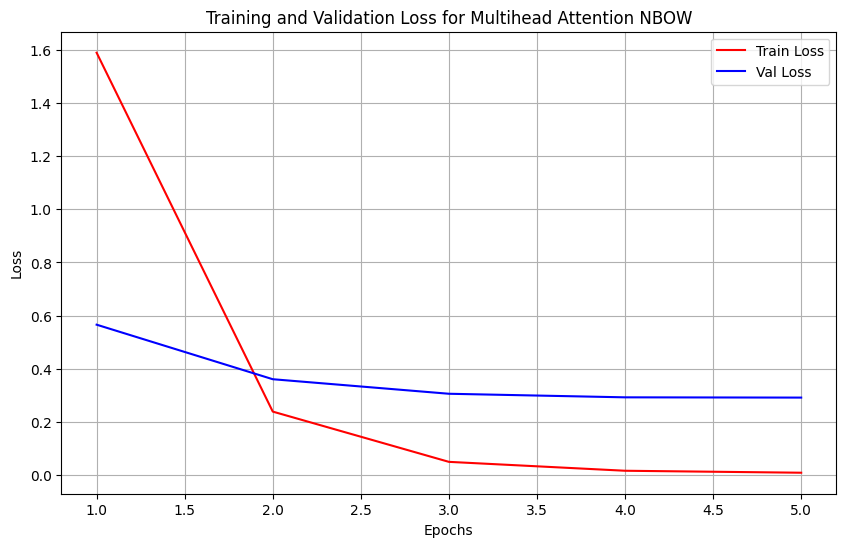

In [59]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits
plot_loss(train_loss_over_time_ma, val_loss_over_time_ma, 'Multihead Attention NBOW')

#### 5.2.3. Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [60]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, num_heads, embedding_dim = get_hyperparams_multihead()
multihead_attention_model = get_multihead_attention_model(vocab_size=len(train_vocab.keys()),embedding_dim=embedding_dim, num_heads=num_heads).to(device)
load_checkpoint(multihead_attention_model, 'multihead_attention')

true, pred, val_loss = val_loop(multihead_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

Final Validation Accuracy: 0.9220159151193634
Final Validation F1-Score: 0.9201634713122898


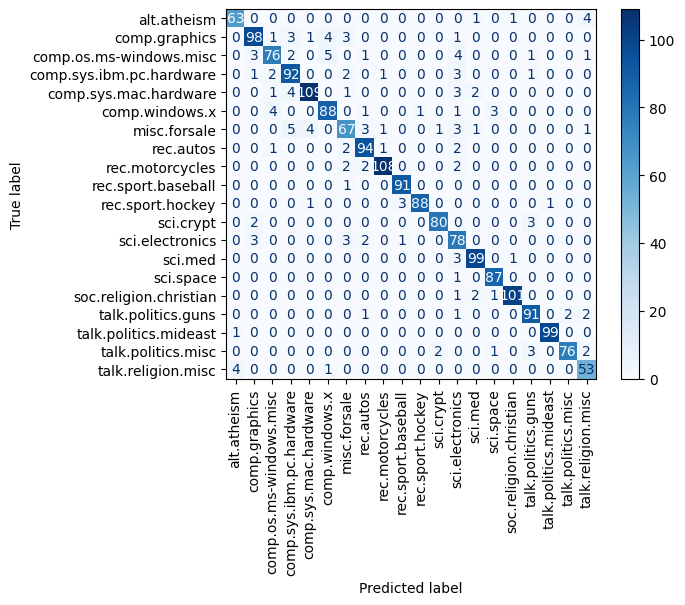

In [61]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 5.3. Self-Attention NBOW [7 points - Programming + 3 points - Non-programming]

Self-attention is a mechanism in neural networks that enables each element in a sequence to consider and weigh the importance of every other element. This facilitates a more nuanced and context-aware representation of the sequence, greatly enhancing the capabilities of models in tasks involving sequential data, particularly in NLP. It has gained prominence with the introduction and success of Transformer models, like BERT, GPT (including GPT-3), and others. This is not a full-fledged implementation of it, but instead a conceptual flavor of the mechanism.

We will now define an encoder that uses a simple form of self-attention when producing attention weights for each word in the sentence:
$$a_{ts} = emb(x_t)^Temb(x_s)$$
$$α_t \propto exp(\sum_s a_{ts})$$
$$h_{self} = \sum α_temb(x_t)$$
Then, the probability of a class is given by
$$softmax(w^Th_{self})$$
The unnormalized attention weight for a word $x$ is computed using the dot product between its embedding and those for all other words in the sentence, followed by a summation and exponentiation. Unlike the model in Section 5.1., this model does not introduce any new parameters for computing the attention function, simply using the same word embeddings for the attention. Therefore, this model has the same number of parameters as the model in Section 2.
For improved stability, we can also add a “residual connection”, which would change Eq. 1 to
$$softmax(w^T(h_{self} + h_{avg}))$$
where $h_{avg}$ is computed as in Section 2 (though using the same word embeddings as in $h_{self}$).


#### 5.3.1. Model Definition [5 points - Programming]
Define your self attention model below

In [62]:
#export
class SelfAttentionNBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, num_classes=20):
        super(SelfAttentionNBOW, self).__init__()
        # YOUR CODE STARTS HERE
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc = nn.Linear(embedding_dim, num_classes, bias=False)

        # YOUR CODE ENDS HERE

    def forward(self, x):
        # YOUR CODE STARTS HERE
        embedded = self.embedding(x)
        pad_mask = (x != 0).float()  # Shape: (BATCH_SIZE, SEQ_LEN
        # Apply mask to embeddings (set embeddings of padding tokens to zero)
        masked_embedded = embedded * pad_mask.unsqueeze(-1)  # Shape: (BATCH_SIZE, SEQ_LEN, embedding_dim)
        # Self-attention calculation (masked embeddings)
        sim_matrix = torch.bmm(masked_embedded, masked_embedded.transpose(1, 2))  # Shape: (BATCH_SIZE, SEQ_LEN, SEQ_LEN)
        # Mask the similarity matrix to ignore padded tokens
        sim_matrix = sim_matrix*pad_mask.unsqueeze(1)*pad_mask.unsqueeze(2)
        # Compute attention weights
        attn_weights = F.softmax(sim_matrix, dim=-1)  # Shape: (BATCH_SIZE, SEQ_LEN, SEQ_LEN)
        # Apply padding mask to the attention weights
        attn_weights = attn_weights * pad_mask.unsqueeze(1)  # Zero out attention weights for padding tokens
        # Normalize attention weights
        attn_weights_sum = attn_weights.sum(dim=-1, keepdim=True)
        attn_weights = attn_weights / attn_weights_sum.clamp(min=1e-9)  # Normalize along the sequence length
        # Calculate self-attention embedding
        self_attention_embedding = torch.bmm(attn_weights, masked_embedded)  # Shape: (BATCH_SIZE, SEQ_LEN, embedding_dim)
        self_attention_avg = self_attention_embedding.mean(dim=1)  # Shape: (BATCH_SIZE, embedding_dim)
        # Calculate average embedding (excluding padded tokens)
        avg_embedding = (masked_embedded.sum(dim=1)) / pad_mask.sum(dim=1, keepdim=True)  # Shape: (BATCH_SIZE, embedding_dim)
        # Combine self-attention and average embeddings
        combined_embedding = self_attention_avg + avg_embedding
        # Final output through fully connected layer
        output = self.fc(combined_embedding)
        return output

        # YOUR CODE ENDS HERE


    def get_embeddings(self, x):
        '''
        This function returns the embeddings of the input x
        '''
        ### YOUR CODE STARTS HERE ###
        return self.embedding(x)
        ### YOUR CODE ENDS HERE ###

    def set_embedding_weight(self, weight):
        '''
        This function sets the embedding weights to the input weight ensure you aren't recording gradients for this
        Args:
            weight: torch.tensor of shape (vocab_size, embedding_dim)
        '''
        ### YOUR CODE STARTS HERE ###
        self.embedding.weight = nn.Parameter(weight)
        ### YOUR CODE ENDS HERE ###

    def get_attention_matrix(self, x):
        '''
        This function returns the normalized attention matrix for the input x
        Args:
            x: torch.tensor of shape (BATCH_SIZE, max seq length in batch)
        Returns:
            attention_weights: torch.tensor of shape (BATCH_SIZE, max seq length in batch, max seq length in batch)
        '''
        ### YOUR CODE STARTS HERE ###
        # Get embeddings
        embedded = self.embedding(x)  # Shape: (BATCH_SIZE, SEQ_LEN, embedding_dim)
        pad_mask = (x != 0).float()   # Shape: (BATCH_SIZE, SEQ_LEN)
        # Apply mask to embeddings
        masked_embedded = embedded * pad_mask.unsqueeze(-1)  # Shape: (BATCH_SIZE, SEQ_LEN, embedding_dim)
        # Compute similarity matrix
        sim_matrix = torch.bmm(masked_embedded, masked_embedded.transpose(1, 2))  # Shape: (BATCH_SIZE, SEQ_LEN, SEQ_LEN)
        # Mask the similarity matrix to ignore padded tokens
        sim_matrix = sim_matrix*pad_mask.unsqueeze(1)*pad_mask.unsqueeze(2)
        # Compute attention scores
        attn_scores = torch.exp(sim_matrix.sum(dim=-1))  # Shape: (BATCH_SIZE, SEQ_LEN)
        # Apply padding mask to attention scores
        attn_scores = attn_scores * pad_mask  # Zero out attention scores for padding
        # Normalize attention weights
        attn_weights = attn_scores / (attn_scores.sum(dim=1, keepdim=True) + 1e-8) # Normalize across sequence
        return attn_weights* pad_mask  # Shape: (BATCH_SIZE, SEQ_LEN)

        ### YOUR CODE ENDS HERE ###


In [63]:
# local test for sanity:
def self_attention_nbow_test_local():
    model = SelfAttentionNBOW(vocab_size=10, embedding_dim=10)
    for _, module in model.named_parameters():
        if hasattr(module, "data"):
            nn.init.constant_(module, 0.3)
    input = torch.tensor([[1,2,3,4,0,0,0],
                          [5,6,7,0,0,0,0]]) % 10

    expected_result = torch.tensor(
        [[1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000],
        [1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000, 1.8000,
         1.8000, 1.8000]]
    )
    with torch.no_grad():
        local_result = model(input)
    if torch.allclose(expected_result, local_result, rtol=0.001):
        print("Passed local check")
    else:
        print(f"Test failed, expected value was\n{expected_result}\nbut you got:\n{local_result}")

def self_attention_nbow_test_local_embeddings():
    model = SelfAttentionNBOW(vocab_size=5, embedding_dim=3)
    model.set_embedding_weight(torch.arange(15).reshape(5, 3) / 50)
    embeddings = model.get_embeddings(torch.tensor([[1, 2, 3, 4, 1], [1, 2, 3, 0, 0]]))
    correct_embeddings = torch.tensor([[[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.2400, 0.2600, 0.2800],
                                        [0.0600, 0.0800, 0.1000]],

                                        [[0.0600, 0.0800, 0.1000],
                                        [0.1200, 0.1400, 0.1600],
                                        [0.1800, 0.2000, 0.2200],
                                        [0.0000, 0.0200, 0.0400],
                                        [0.0000, 0.0200, 0.0400]]])
    if torch.allclose(embeddings, correct_embeddings, rtol=0.001):
        print("Passed local embedding test")
    else:
        print(f"Embedding Test failed, expected value was\n{correct_embeddings}\nbut you got:\n{embeddings}")

def self_attention_nbow_test_local_attn():
    model = SelfAttentionNBOW(vocab_size=5, embedding_dim=3)
    model.set_embedding_weight(torch.arange(15).reshape(5,3) / 50)
    attention_weights = model.get_attention_matrix(torch.tensor([[1,2,3,4,1],[1,2,3,0,0]]))
    correct_attention_weights = torch.tensor([[0.1675, 0.1921, 0.2203, 0.2526, 0.1675],
        [0.3085, 0.3327, 0.3588, 0.0000, 0.0000]])
    if torch.allclose(attention_weights, correct_attention_weights, rtol=0.001):
        print("Passed local Attn test")
    else:
        print(f"Attn Test failed, expected value was\n{correct_attention_weights}\nbut you got:\n{attention_weights}")
self_attention_nbow_test_local()
self_attention_nbow_test_local_embeddings()
self_attention_nbow_test_local_attn()


Passed local check
Passed local embedding test
Passed local Attn test


In [64]:
#export
def get_self_attention_model(vocab_size, embedding_dim):
    """
    This function returns an instance of the Self Attention model. Initialize the Self Attention model here and return it.
    """
    model = None
    ## YOUR CODE STARTS HERE ##
    model = SelfAttentionNBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
    ## YOUR CODE ENDS HERE ##
    return model

#### 5.3.2. Model Training [3 points - Non-Programming]
Assign and tune the below hyperparameters to optimize your model

In [65]:
#export
# Assign hyperparameters and training parameters
# Experiment with different values for these hyperparaters to optimize your model's performance
def get_hyperparams_self_attn():
    learning_rate = 0.01
    epochs = 5
    embedding_dim = 100
    return learning_rate, epochs, embedding_dim

In [66]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_self_attn()
self_attention_model = get_self_attention_model(len(train_vocab.keys()),embedding_dim).to(device)
criterion = get_criterion()
optimizer = get_optimizer(self_attention_model, learning_rate)
train_loss_over_time_sea = []
val_loss_over_time_sea = []
for epoch in range(epochs):
    train_loss = train_loop(self_attention_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(self_attention_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_sea.append(train_loss)
    val_loss_over_time_sea.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")
save_checkpoint(self_attention_model, 'self_attention')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 36.75it/s]


Epoch 1 -- Train_Loss: 2.0709251392695864 -- Val_Loss: 1.0367215394973754 -- Val_Accuracy: 0.7761273209549071 -- Val_F1: 0.7707176372398947


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 37.46it/s]


Epoch 2 -- Train_Loss: 0.5035496894585885 -- Val_Loss: 0.4569123009840647 -- Val_Accuracy: 0.8848806366047746 -- Val_F1: 0.8813584322910575


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 35.52it/s]


Epoch 3 -- Train_Loss: 0.1503601456850262 -- Val_Loss: 0.3559968610604604 -- Val_Accuracy: 0.9124668435013262 -- Val_F1: 0.9101257286957953


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 35.95it/s]


Epoch 4 -- Train_Loss: 0.057446977597171975 -- Val_Loss: 0.3189230650663376 -- Val_Accuracy: 0.9220159151193634 -- Val_F1: 0.9189028300101223


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 35.59it/s]


Epoch 5 -- Train_Loss: 0.02717917655610432 -- Val_Loss: 0.3070492168267568 -- Val_Accuracy: 0.9214854111405836 -- Val_F1: 0.9188826212771224
Checkpoint saved to /content/drive/MyDrive/CS 7650/HW1/model_weights/checkpoint_self_attention_ce.pt


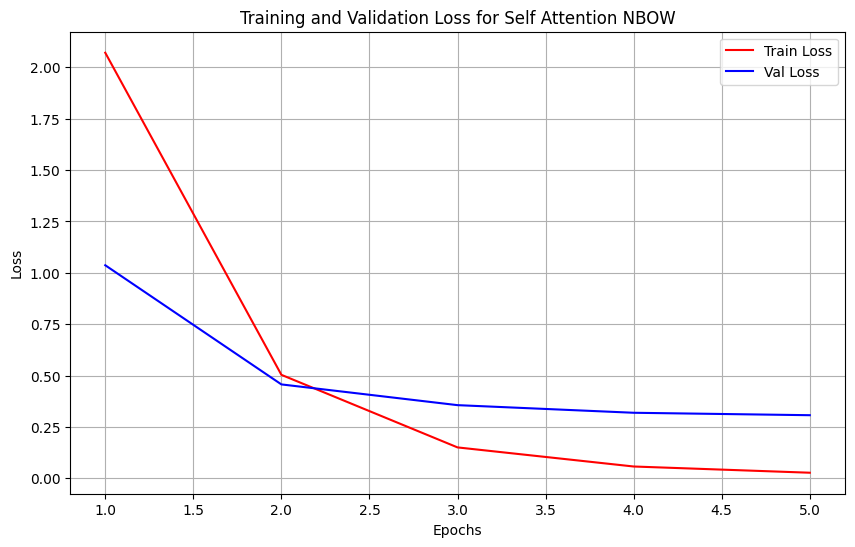

In [67]:
# DO NOT CHANGE THIS CELL - retain the outputs in submission PDF for credits
plot_loss(train_loss_over_time_sea, val_loss_over_time_sea, 'Self Attention NBOW')

#### 5.3.3. Model Evaluation Model Evaluation [2 points - Programming]
The final points for this will be awarded as per Gradescope's test split, which is different from the local versions. The cell below is just for a sanity check. Your metrics here may not exactly match with the ones on Gradescope, but if your model is fairly generalized, it should not be far off.
- 0 points for accuracy <= 85%
- 1 point for accuracy > 85% but <= 90%
- 2 points for accuracy > 90%

In [68]:
# DO NOT CHANGE THIS CELL
learning_rate, epochs, embedding_dim = get_hyperparams_self_attn()
self_attention_model = get_self_attention_model(len(train_vocab.keys()),embedding_dim).to(device)
load_checkpoint(self_attention_model, 'self_attention', map_location=device)

true, pred, val_loss = val_loop(self_attention_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

Final Validation Accuracy: 0.9214854111405836
Final Validation F1-Score: 0.9188826212771224


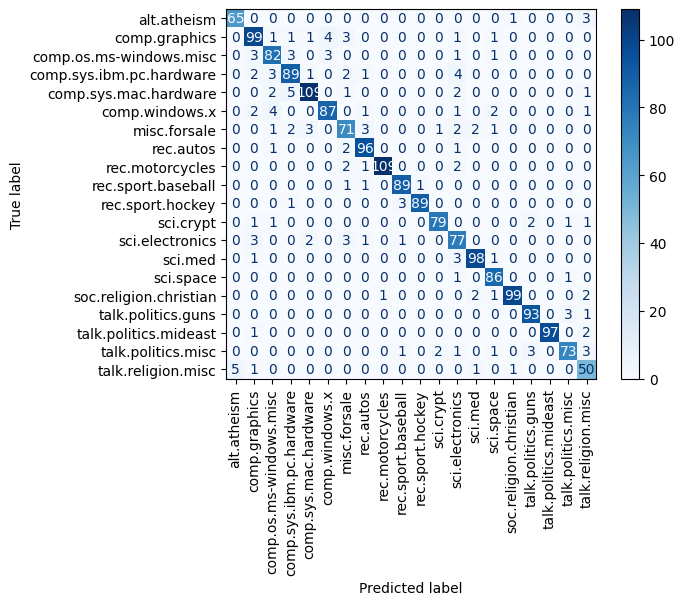

In [69]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 6. Perceptron and Hinge Losses (16 Points - Programming)



### 6.1. Perceptron Loss (5 points - Programming)

The perceptron loss penalizes the model only when the true class is not the most confident prediction. If the model incorrectly assigns a higher score to another class, the perceptron loss encourages the model to adjust its weights to fix this mistake.

This is achieved by considering the difference between the maximum score among all other classes and the score of the true class. If the maximum incorrect score is higher than the true class score, the model receives a penalty proportional to how much worse the true class was predicted compared to the highest incorrect class.

Given a set of predictions from the perceptron model for a batch of samples, we denote:

- $ \mathbf{y} \in \mathbb{R}^{B \times C} $: The matrix of predicted scores, where $B$ is the batch size and $C$ is the number of classes. Each row represents the predicted scores for one sample.
- $\mathbf{y}_{\text{true}} \in \{0, 1, \ldots, C-1\}^{B}$: The ground truth labels, where each entry is an integer representing the correct class label for each sample.

For a given sample \( i \), let:

- $s_j $ be the score for class $j$ (from the predicted score vector).
- $ s_{\text{true}} $ be the score for the true class.

The **perceptron loss** for data instance $x_i$ is defined as:

$$
L_{\text{perceptron}}(i) = \max \left( 0, \max_{j} (s_j) - s_{\text{true}} \right)
$$

For batches, we compute the loss for each sample and take the mean over the batch

Implement this PerceptronLoss in the forward method below.

NOTE: The scores are logits, the predictions of models before doing any softmax.


In [70]:
# export

class PerceptronLoss(nn.Module):
    def __init__(self):
        super(PerceptronLoss, self).__init__()

    def forward(self, predictions, labels):
        """
        Calculate the perceptron loss between predictions and labels.

        Args:
            predictions (torch.Tensor): The predictions from the model for a batch of inputs.
                                        Shape should be (batch_size, num_classes).
            labels (torch.Tensor): The ground truth labels for each input in the batch.
                                   Shape should be (batch_size,) with each value between 0 and num_classes-1.

        Returns:
            scalar: The mean perceptron loss for the batch.
        """
        loss = None
        # YOUR CODE STARTS HERE
        # Extract the true class scores from the predictions using advanced indexing
        true_class_scores = predictions.gather(1, labels.unsqueeze(1)).squeeze(1)  # (batch_size,)

        # Find the maximum score across all classes for each sample
        max_other_scores = predictions.max(dim=1).values  # (batch_size,)

        # Compute the perceptron loss: max(0, max_other_scores - true_class_scores)
        loss_per_sample = torch.clamp(max_other_scores - true_class_scores, min=0)  # (batch_size,)

        # Return the mean loss across the batch
        loss = loss_per_sample.mean()

        # YOUR CODE ENDS HERE
        return loss

In [71]:
# DO NOT CHANGE THIS CELL
perceptron_loss = PerceptronLoss()

def test_correct_classification():
    predictions = torch.tensor([[3.0, 2.0, 1.0],
                                [1.0, 4.0, 2.0]])
    labels = torch.tensor([0, 1])
    loss = perceptron_loss(predictions, labels).item()
    expected_loss = 0.0
    rtol = 0.001  # Relative tolerance
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case passed for correct classification')
    else:
        print(f"Test case failed for correct classification, expected value was\n{expected_loss}\nbut you got:\n{loss}")

# Test for incorrect classification
def test_incorrect_classification():
    predictions = torch.tensor([[1.0, 3.0, 2.0],
                                [1.0, 2.0, 4.0]])
    labels = torch.tensor([0, 1])

    expected_loss = 2.0
    loss = perceptron_loss(predictions, labels).item()

    rtol = 0.001  # Relative tolerance
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case passed for incorrect classification')
    else:
        print(f"Test case failed for incorrect classification, expected value was\n{expected_loss}\nbut you got:\n{loss}")

# Execute test cases
test_correct_classification()
test_incorrect_classification()

Test case passed for correct classification
Test case passed for incorrect classification


### 6.2. NBOW Training using Perceptron Loss (3 points - Programming)

Credits will be awarded as per the following final results on the Gradescope split -
- 0 points for accuracy <= 75%
- 1 point for accuracy > 75% but <= 80%
- 2 points for accuracy > 80%

In [72]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
criterion = PerceptronLoss()
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_perceptron = []
val_loss_over_time_perceptron = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_perceptron.append(train_loss)
    val_loss_over_time_perceptron.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

save_checkpoint(nbow_model, 'nbow', loss_fn='perceptron')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 40.36it/s]


Epoch 1 -- Train_Loss: 0.07032769779532642 -- Val_Loss: 0.017229636386036872 -- Val_Accuracy: 0.7071618037135279 -- Val_F1: 0.7039888057605574


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 39.31it/s]


Epoch 2 -- Train_Loss: 0.011381900478627974 -- Val_Loss: 0.017675099397699037 -- Val_Accuracy: 0.7729442970822281 -- Val_F1: 0.7720188400464307


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 35.85it/s]


Epoch 3 -- Train_Loss: 0.006444708094932139 -- Val_Loss: 0.017509048307935395 -- Val_Accuracy: 0.8153846153846154 -- Val_F1: 0.8153171278277744


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 38.74it/s]


Epoch 4 -- Train_Loss: 0.004209144903698115 -- Val_Loss: 0.017827364740272363 -- Val_Accuracy: 0.8190981432360742 -- Val_F1: 0.8186507039576499


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 36.47it/s]


Epoch 5 -- Train_Loss: 0.002915886399963618 -- Val_Loss: 0.01693786246081193 -- Val_Accuracy: 0.83342175066313 -- Val_F1: 0.8338461240690254
Checkpoint saved to /content/drive/MyDrive/CS 7650/HW1/model_weights/checkpoint_nbow_perceptron.pt


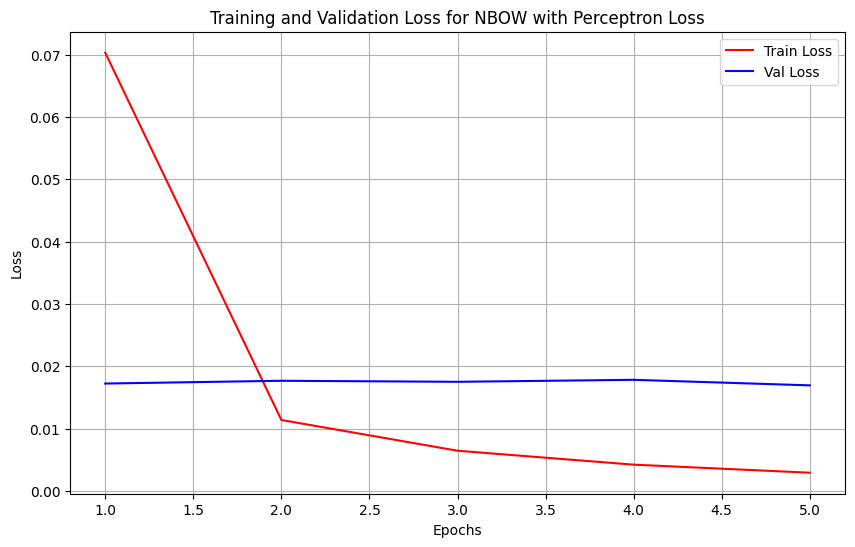

In [73]:
# DO NOT CHANGE THIS CELL
plot_loss(train_loss_over_time_perceptron, val_loss_over_time_perceptron, 'NBOW with Perceptron Loss')

In [74]:
# DO NOT CHANGE THIS CELL
# load best model from checkpoint
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'perceptron', map_location=device)

# evaluate model
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

Final Validation Accuracy: 0.83342175066313
Final Validation F1-Score: 0.8338461240690254


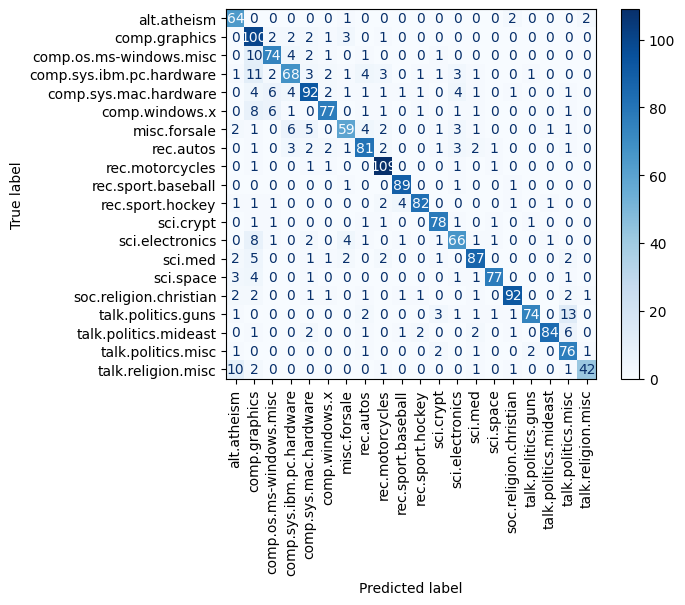

In [75]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

### 6.3. Hinge Loss (5 points - Programming)

Read through the dataset documentation link provided with this notebook, or feel free to Google and read about 20 Newsgroups dataset, it's quite popular. If you try to understand the labels, they are more similar to some of them than others, semantically. For example, `talk.politics.mideast` is more closer to `talk.politics.misc` than `sci.space`.

Mathematically speaking, it means that misclassification of a label to some classes may be less penalizable than some other classes. This is the perfect scenario of using hinge loss.

The **hinge loss** is another loss function commonly used for classification, especially in **support vector machines (SVMs)**. It is designed to maximize the margin between the decision boundary and the closest data points from each class.

The hinge loss penalizes predictions based on how confident the model is about the correct class relative to other classes. It aims to push the score of the true class far above the scores of all other classes, ensuring that the model not only predicts the correct class but does so confidently.

For each input sample $x_i$, the model computes a score for each class. The hinge loss compares the score for the true class to the scores for all other classes and penalizes the model if the true class score is not sufficiently higher than the scores for the other classes.

Given a set of predictions from the model for a batch of samples, we denote:

- $\mathbf{y} \in \mathbb{R}^{B \times C}$: The matrix of predicted scores, where $B$ is the batch size and $C$ is the number of classes. Each row represents the predicted scores for one sample.
- $\mathbf{y}_{\text{true}} \in \{0, 1, \ldots, C-1\}^{B}$: The ground truth labels, where each entry is an integer representing the correct class label for each sample.

For a given sample \( i \), let:

- $s_j$ be the score for class $j$ (from the predicted score vector).
- $s_{\text{true}}$ be the score for the true class.
- $l(j, true)$ be the cost if a task instance belonging to $true$ has highest score for $j$

The **hinge loss** for a task instance \( x_i \) is defined as:

$$
L_{\text{hinge}}(i) = \max \left( 0, \max_j\left(s_j + l(j, true)\right) - s_{\text{true}}\right)
$$

For batches, we compute the loss for each sample and take the mean over the batch to obtain a scalar value representing the average hinge loss.

HINT: The non-recommended solution is to use one loop. However, it is highly recommended to not do that for efficiency reasons. `torch.gather()` should be helpful.


In [76]:
# export
class HingeLoss(nn.Module):
    def __init__(self, cost_matrix, device):
        super(HingeLoss, self).__init__()
        """
        cost_matrix is a 2D list. Convert it to a tensor on appropriate device.
        """
        # YOUR CODE STARTS HERE
        self.cost_matrix = torch.tensor(cost_matrix, dtype=torch.float32, device=device)
        # YOUR CODE ENDS HERE

    def forward(self, predictions, labels):
        """
        Calculate the hinge loss between predictions and labels, adjusting for cost.

        Args:
            predictions (torch.Tensor): The predictions from the model for a batch of inputs.
                                        Shape should be (batch_size, num_classes).
            labels (torch.Tensor): The ground truth labels for each input in the batch.
                                   Shape should be (batch_size,) with each value between 0 and num_classes-1.

        Returns:
            scalar: The mean hinge loss for the batch, adjusted for the defined cost.
        """
        loss = None
        # YOUR CODE STARTS HERE
        batch_size, num_classes = predictions.shape

        # Gather the scores for the true classes
        true_class_scores = predictions.gather(1, labels.view(-1, 1)).squeeze(1)  # Shape (batch_size,)

        # Create a matrix of the cost values for each (predicted, true) pair
        cost_for_labels = self.cost_matrix[labels]  # Shape (batch_size, num_classes)

        # Calculate the hinge loss for each class other than the true class
        # max(0, s_j + l(j,true) - s_true)
        margin_losses = predictions + cost_for_labels - true_class_scores.view(-1, 1)  # Shape (batch_size, num_classes)

        # We only penalize for wrong predictions, so we set the true class margin to 0
        margin_losses.scatter_(1, labels.view(-1, 1), 0)

        # Calculate the maximum hinge loss across all classes for each sample
        max_margin_loss = torch.clamp(margin_losses, min=0).max(dim=1)[0]  # Shape (batch_size,)

        # Return the mean loss over the batch
        loss = max_margin_loss.mean()

        # YOUR CODE ENDS HERE
        return loss

In [77]:
# DO NOT CHANGE THIS CELL
def test_correct_classification(hinge_loss):
    """
    Test case where the true class has the highest score.
    The loss should be 0.
    """
    rtol = 0.0001
    predictions = torch.tensor([[3.0, 2.0, 1.0],
                                [1.0, 4.0, 2.0]])
    labels = torch.tensor([0, 1])
    loss = hinge_loss(predictions, labels).item()
    expected_loss = 0.0
    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case 1 passed')
    else:
        print(f"Test case 1 failed, expected value was\n{expected_loss}\nbut you got:\n{loss}")

def test_incorrect_classification(hinge_loss):
    """
    Test case where the true class does not have the highest score.
    The loss should be greater than 0.
    """
    rtol = 0.0001
    predictions = torch.tensor([[1.0, 3.0, 2.0],
                                [1.0, 2.0, 4.0]])
    labels = torch.tensor([0, 1])

    expected_loss = 3.0
    loss = hinge_loss(predictions, labels).item()

    if abs(expected_loss - loss) <= rtol * abs(expected_loss):
        print('Test case 2 passed')
    else:
        print(f"Test case 2 failed, expected value was\n{expected_loss}\nbut you got:\n{loss}")

cost_matrix = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
hinge_loss = HingeLoss(cost_matrix, device='cpu')
test_correct_classification(hinge_loss)
test_incorrect_classification(hinge_loss)

Test case 1 passed
Test case 2 passed


### 6.4. NBOW Training using Hinge Loss [3 points - Programming]

First, define a cost matrix. Take inspiration from the confusion matrix of `PerceptronLoss` results, `id2label` map and your knowledge of what dataset labels are. This will help is constructing a good cost matrix.

Credits will be awarded on the following cutoffs on Gradescope split -
- 0 points for accuracy <= 84%,
- 1 point for accuracy > 84% but <= 88%,
- 2 points for accuracy > 88%

In [78]:
# export
def get_cost_matrix(num_classes=20):
    """
    Generates a cost matrix for a specified number of classes using Python lists.

    Args:
        num_classes (int): The number of classes for which the cost matrix is to be created.

    Returns:
        list of lists: A 2D list where element (i, j) is the absolute difference between i and j,
                       set to zero if i equals j.
    """
    cost_matrix = None
    # YOUR CODE STARTS HERE
    # Initialize the cost matrix as a list of lists
    cost_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]

    # Fill the cost matrix with the absolute differences
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:
                cost_matrix[i][j] = abs(i - j)
    # YOUR CODE ENDS HERE
    return cost_matrix

In [79]:
# DO NOT CHANGE THIS CELL
def test_cost(matrix):
    n = len(matrix)

    # Check if the matrix is square
    for row in matrix:
        if len(row) != n:
            print('Incorrect cost matrix: Not a square matrix.')

    # Check for symmetry and zero diagonal elements
    for i in range(n):
        if matrix[i][i] != 0:
            print('Incorrect cost matrix: Diagonal elements are not zero.')

        for j in range(i + 1, n):
            if matrix[i][j] != matrix[j][i]:
                print('Incorrect cost matrix: Not a symmetric matrix.')

    print('Valid cost matrix')

cost_matrix = get_cost_matrix()
test_cost(cost_matrix)

Valid cost matrix


In [80]:
# This is the main training loop. You'll need to complete the train_loop and val_loop functions.
# You'll also need to complete the criterion and optimizer functions.
# Feel free to experiment with different optimizers and learning rates.
# Do not change anything else in this cell
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
cost_matrix = get_cost_matrix()
criterion = HingeLoss(cost_matrix, device=device)
optimizer = get_optimizer(nbow_model, learning_rate)
train_loss_over_time_hinge = []
val_loss_over_time_hinge = []
for epoch in range(epochs):
    train_loss = train_loop(nbow_model, criterion, optimizer, train_iterator, epoch, save_every=2)
    true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
    accuracy, f1 = get_accuracy_and_f1_score(true, pred)
    train_loss_over_time_hinge.append(train_loss)
    val_loss_over_time_hinge.append(val_loss)
    print(f"Epoch {epoch+1} -- Train_Loss: {train_loss} -- Val_Loss: {val_loss} -- Val_Accuracy: {accuracy} -- Val_F1: {f1}")

save_checkpoint(nbow_model, 'nbow', loss_fn='hinge')

Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 38.43it/s]


Epoch 1 -- Train_Loss: 9.07959710541418 -- Val_Loss: 6.309352175394694 -- Val_Accuracy: 0.27586206896551724 -- Val_F1: 0.19416171976217783


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 37.36it/s]


Epoch 2 -- Train_Loss: 4.0229788675146585 -- Val_Loss: 2.8820475260416667 -- Val_Accuracy: 0.7055702917771883 -- Val_F1: 0.6528053606422601


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 39.67it/s]


Epoch 3 -- Train_Loss: 1.6523745065018283 -- Val_Loss: 1.884443457921346 -- Val_Accuracy: 0.8450928381962864 -- Val_F1: 0.8325464795806738


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 39.95it/s]


Epoch 4 -- Train_Loss: 0.7593922526654551 -- Val_Loss: 1.5539032459259032 -- Val_Accuracy: 0.8795755968169762 -- Val_F1: 0.8751100643370586


Evaluating Model: 100%|██████████| 15/15 [00:00<00:00, 40.62it/s]


Epoch 5 -- Train_Loss: 0.3823917918538643 -- Val_Loss: 1.489884650707245 -- Val_Accuracy: 0.8917771883289125 -- Val_F1: 0.8894111374364817
Checkpoint saved to /content/drive/MyDrive/CS 7650/HW1/model_weights/checkpoint_nbow_hinge.pt


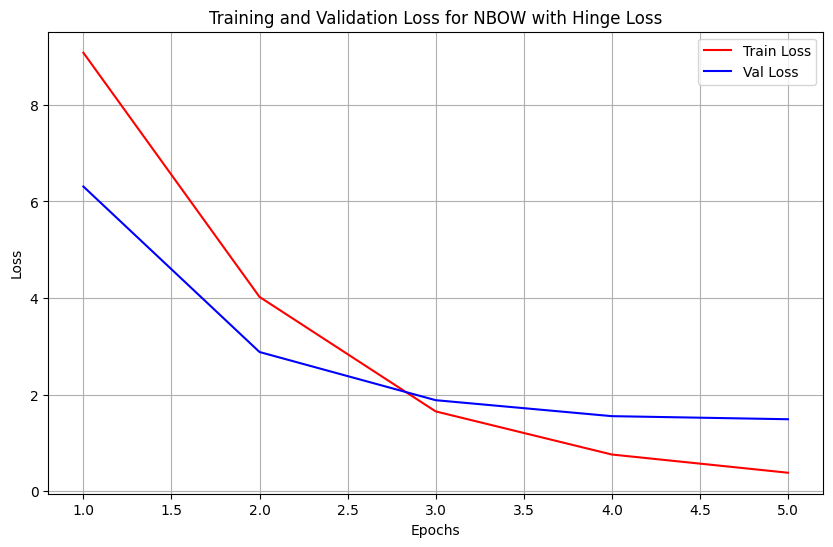

In [81]:
# DO NOT CHANGE THIS CELL
plot_loss(train_loss_over_time_hinge, val_loss_over_time_hinge, 'NBOW with Hinge Loss')

In [82]:
# DO NOT CHANGE THIS CELL
# load best model from checkpoint
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'hinge', map_location=device)

# evaluate model
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
accuracy, f1 = get_accuracy_and_f1_score(true, pred)
print(f"Final Validation Accuracy: {accuracy}")
print(f"Final Validation F1-Score: {f1}")

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

Final Validation Accuracy: 0.8917771883289125
Final Validation F1-Score: 0.8894111374364817


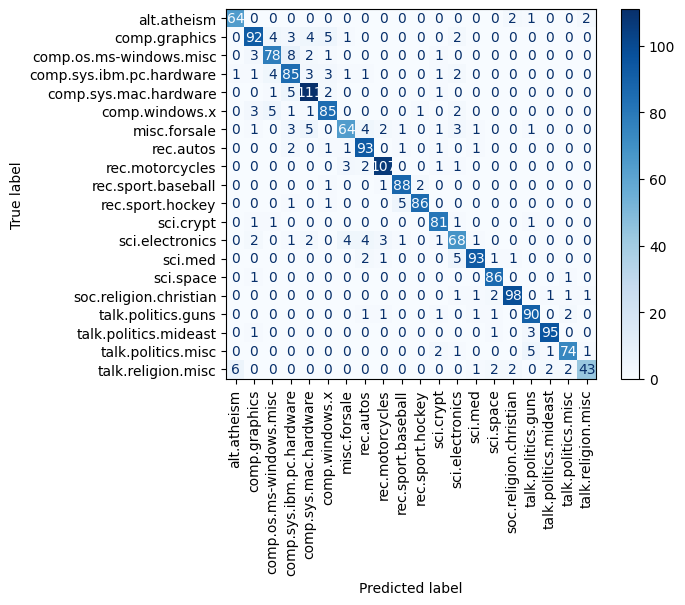

In [83]:
# DO NOT CHANGE THIS CELL
plot_confusion_matrix(true, pred, classes=id2label.values())

## 7. Analysis [21 Points - Non-programming]

These are some analytical questions based on implementations done above.

Note for all analysis questions: Be sure to isolate all your code/textual answers into separate cells without modifying code in other exported functions as they are still used for grade scope test cases. Feel free to add as many code and markdown cells as you see fit to explain your answer.

Code should be in code cells and write-ups should strictly be in markdown cells. Please note, these will be manually evaluated due to large variation in possible answers. So, visibility of code, explanation and output in the PDF is the key.

### 7.1. Analyzing NBOW Weights [7 points - Non-programming]

Load your trained `NBOW` model here, and let $w$ be the weight of your linear layer of the model. It will be of the shape of `(num_classes, embedding_dim)`.

For this tensor, compute $ww^T$ and show it as a heatmap (a sample code to generate heatmap is shown below).

Explain the generated output. What does it resemble? What do high and low values of coefficients at position i, j indicate? With the help of the dataset documentation and `id2label` map displayed earlier in this notebook, can you reason why certain values are high and why certain values are low? What does it tell you about the class labels?

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

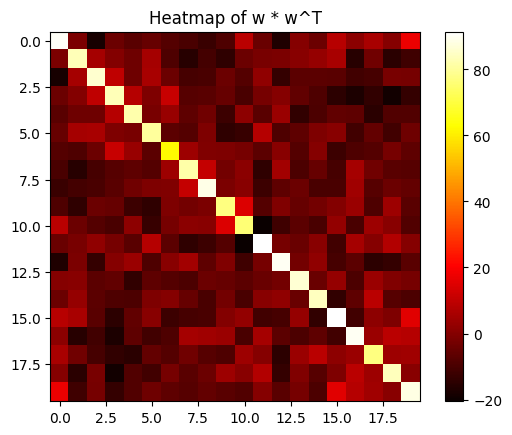

In [84]:
# YOUR CODE HERE
# Example Heatmap Generation Code
# matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# # Display heatmap using Matplotlib
# plt.imshow(matrix, cmap='hot', interpolation='nearest')
# plt.colorbar()  # Add a color bar to show the scale
# plt.title('Heatmap using Matplotlib')
# plt.show()

learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', map_location=device)

w = nbow_model.fc.weight
w_wt = torch.matmul(w, w.T)
w_wt_np = w_wt.detach().cpu().numpy()

plt.imshow(w_wt_np, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add a color bar to show the scale
plt.title('Heatmap of w * w^T')
plt.show()


The matrix resembles a butterfly. The values on th matrix represents the dot product between the weight vectors for class i and j. High values along the diagonal indicate that the weight vectors from i's and j's in this area have large magnitude, which means that the model assigns more signifficance to the classes here. For i's and j's that are less similar to each other (not on the diagnoal), high values indicate that the corresponding classes i and j are more alike whereas low values indicate that they are not much alike.

As for reasons behind high and low values, we see high values along the diagonal because i = j in this area, which means that i and j are the same class. For high values not on the diagonal, this is because the two classes are similar to each other; they could be semantically related or share similar context, so higher weights are assigned to them and yield higher values on the matrix. For low values off the diagonal, this is because the two classes are very different from each other and share very few features in the embedding space. So low weights are assigned to them/their interactions and we see low values on the matrix for those class labels that are very distinct to each other.

### 7.2. Word Embeddings and the Attention Vector [7 points - Non Programming]

From your trained `SimpleAttentionNBOW` model, analyze all word embeddings and the attention vector `u`. Look at the words which have the highest cosine similarity with `u`. Print the 15 words with highest cosine similarity to `u` and the 15 with lowest cosine similarity to `u`. Why do you think those words have high/low cosine similarity to `u` (and therefore high/low attention weights on average)? Form a hypothesis to explain what you see.

In [85]:
# YOUR CODE HERE
embedding_matrix = simple_attention_model.embedding.weight
u = simple_attention_model.attention_u

u_norm = F.normalize(u, p=2, dim=0)
embedding_norms = F.normalize(embedding_matrix, p=2, dim=1)

cosine_similarities = torch.matmul(embedding_norms, u_norm)
cosine_similarities_np = cosine_similarities.detach().cpu().numpy()

top_15_indices = np.argsort(cosine_similarities_np)[-15:][::-1]
bottom_15_indices = np.argsort(cosine_similarities_np)[:15]

df_vocab, df_reverse_vocab = generate_vocab_map(df)
id2word = {v: k for k, v in df_vocab.items()}

print("Top 15 words with highest cosine similarity to u:")
for idx in top_15_indices:
    print(f"Word: {id2word[idx]}, Cosine Similarity: {cosine_similarities_np[idx]}")
print("Top 15 words with lowest cosine similarity to u:")
for idx in bottom_15_indices:
    print(f"Word: {id2word[idx]}, Cosine Similarity: {cosine_similarities_np[idx]}")

Top 15 words with highest cosine similarity to u:
Word: academic, Cosine Similarity: 0.40220123529434204
Word: boeing, Cosine Similarity: 0.3937370181083679
Word: socket, Cosine Similarity: 0.38070082664489746
Word: kiss, Cosine Similarity: 0.3768883943557739
Word: clyinder, Cosine Similarity: 0.37363672256469727
Word: playoffs, Cosine Similarity: 0.37250611186027527
Word: couriers, Cosine Similarity: 0.36725908517837524
Word: represents, Cosine Similarity: 0.3629065752029419
Word: suppliers, Cosine Similarity: 0.3608192205429077
Word: cookson, Cosine Similarity: 0.35940879583358765
Word: immunex.com, Cosine Similarity: 0.3578329384326935
Word: 173, Cosine Similarity: 0.3574509024620056
Word: favors, Cosine Similarity: 0.357241690158844
Word: tape, Cosine Similarity: 0.3564213514328003
Word: danny, Cosine Similarity: 0.35261842608451843
Top 15 words with lowest cosine similarity to u:
Word: \, Cosine Similarity: -0.8134840726852417
Word: ,, Cosine Similarity: -0.6722593307495117
Word: 

Words with high cosine similarity to 𝑢 are generally important and decisive to categorize texts at hand. They are words that can better help a model identify the content, sentiment, or other key elements in the texts and therefore carry more weights that influences a model's decision. In other words, they deserve more attention from the model to make accurate text classifications. On the other hand, words with low consine similarity to 𝑢 are less informative in terms of identifying key contents from the texts. They are words like mere symbols, conjunctures, or prepositions which are less helpful to understand and classify the texts. Therefore, they do not deserve much attention from the model and carry less weight.

### 7.3. Analysis of Cost Matrix in Hinge Loss [7 points - Non-programming]

Display the confusion matrices of prediction of `NBOW` with `PerceptronLoss` and `HingeLoss`. Also print the cost matrix you used for the Hinge Loss.

Using this confusion matrix, `id2label` mapping provided earlier, your knowledge about what labels in the dataset represent, explain the motivation behind creating the provided cost matrix. Why were some of the coefficients higher than others (if)?

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

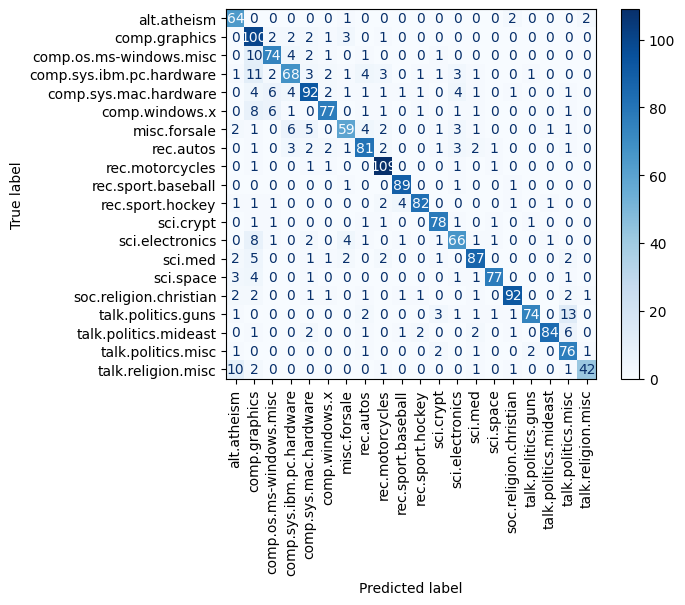

In [86]:
# YOUR CODE HERE
# confusion matrix of prediction of NBOW with PerceptronLoss
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'perceptron', map_location=device)
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
plot_confusion_matrix(true, pred, classes=id2label.values())

<ipython-input-6-e164f9413248>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=map_location) # load the checkpoint, ensure 

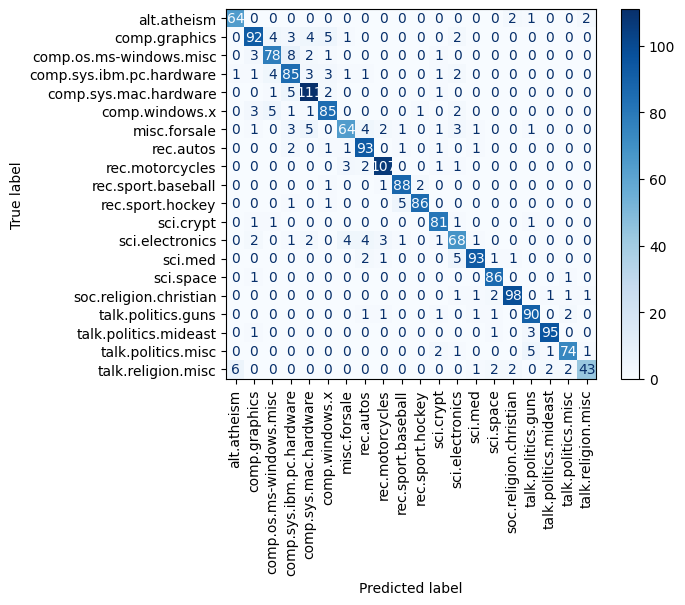

In [87]:
# confusion matrix of prediction of NBOW with HingeLoss
learning_rate, epochs, embedding_dim = get_hyperparams_nbow()
nbow_model = get_nbow_model(vocab_size= len(train_vocab.keys()), embedding_dim = embedding_dim).to(device)
load_checkpoint(nbow_model, 'nbow', 'hinge', map_location=device)
true, pred, val_loss = val_loop(nbow_model, criterion, val_iterator)
plot_confusion_matrix(true, pred, classes=id2label.values())


In [88]:
# Print cost matrix for Hinge Loss
print("Cost Matrix for Hinge Loss:")
print(np.array(cost_matrix))

Cost Matrix for Hinge Loss:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
 [ 2  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 [ 3  2  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10]
 [10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9]
 [11 10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8]
 [12 11 10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7]
 [13 12 11 10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6]
 [14 13 12 11 10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5]
 [15 14 13 12 11 10  9  8  

Higher coefficients in the cost matrix indicate higher stakes for misclassifications. Misclassifying a class that is semantically distant from the true class implies a greater error in understanding the input, and the model should be penalized more heavily to avoid such mistakes. For example, the cost to misclassifying atheism to religion is much higher than misclassifying baseball to hockey because the first pair is clearly much more distinct from each other than the second pair. The first misclassification would yield a complete opposite meaning and lead to a severe mistake, while the second one would still yield a meaning that can fall under the umbrella of sports. This also makes sense as to why the cost to correct classification is 0 because there won't be any misunderstanding if everything is correct, so we should not penalize that. These are the reasons why some of the coefficients in the cost matrix is higher than others.

## 8. Improving Attention Models [BONUS] [10 points - Non-programming]

Hopefully you’ve developed some intuition for using attention for this task. Now, come up with your own ways of modifying the attention function and experiment with them. Can you find an idea that outperforms your models from Sections 5?
Some potential ideas are below:
- Use transformation matrices to distinguish key, query, and value representations
- Add additional layers of self-attention before the attention-weighted sum of embeddings
- Compute features in the attention function based on characteristics of where the word is in the sentence, e.g., features of the sentence length, nearby words, the presence of negation words before or after the word, information from a part-of-speech tagger or syntactic parse of the sentence, etc.
- Use multiple word embedding spaces for when words are used as keys, queries, and values, or some subset of the three.

Describe your best new attention function formally below, along with the execution code and experimental results. Add as many code and markdown cells as you want, and submit the complete working with explanation.

## 9. Submitting Your Assignment

This is the end. Congratulations!  

Now, follow the steps below to submit your homework on Gradescope.

### 9.1. Programming

The programming will be evaluated through an autograder. To create the file to submit for autograder, follow the steps below -
1. Open a terminal from the root directory of the project
2. Run the collect_submission.py file
3. Agree to the Late Policy and Honor Pledge
4. After the file is executed, your root project will have a submission directory.
5. Submit all the contents of this file to GradeScope

### 9.2. Non-Programming

The analysis parts will be evaluated manually. For this, export the notebook to a PDF file, and submit it on GradeScope. Please ensure no written code or output is clipped when you create your PDF. One reliable way to do it is first download it as HTML through Jupyter Notebook and then print it to get PDF.